In [1]:
its_jupyter_notebook = True

In [2]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from models.nt_classifier import build as build_model
from config import *
from util.plot_utils import obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops10select_int4callERKNS_6TensorEll
  warn(f"Failed to load image Python extension: {e}")


In [3]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'binary_cl2') #binary_cl2_old_best, binary_cl2_4

In [4]:
# Define the path to the file containing the args namespace
args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)
    
print(args_dict)

{'lr': 0.0001, 'lr_backbone': 0.0001, 'batch_size': 32, 'weight_decay': 0.0001, 'epochs': 100, 'lr_drop': 200, 'clip_max_norm': 0.1, 'proj_module_N_channels': 0, 'proj_module_secondary_structure_N_channels': 4, 'drop_secondary_structure': False, 'use_projection_module': False, 'dropout_prob': 0.01, 'args.mini_batch_size': 32, 'num_hidden_layers': 1, 'dividing_factor': 20, 'output_channels_mlp': 400, 'n_channels1_cnn': 256, 'n_channels2_cnn': 512, 'min_n_groups_train': 5, 'max_n_groups_train': 80, 'min_n_groups_val': 80, 'max_n_groups_val': 80, 'policies_train': [<dataset.data.EasyPosAugment object at 0x7f2bbef7b850>, <dataset.data.SmartNegAugment object at 0x7f2bbef964a0>], 'policies_val': [<dataset.data.EasyPosAugment object at 0x7f2ab854f100>, <dataset.data.SmartNegAugment object at 0x7f2ab854c6d0>], 'dataset_path': '/data01/giorgio/RNARNA-NT/dataset', 'device': 'cuda', 'seed': 42, 'num_workers': 2, 'output_dir': '/data01/giorgio/RNARNA-NT/checkpoints/binary_cl2', 'resume': '', 'star

In [5]:
#args_dict['policies_train'][0].height_probabilities

In [6]:
#args_dict['policies_train'][0].height_bins

In [7]:
file_train = os.path.join(rna_rna_files_dir, "gene_pairs_training_nt.txt")
with open(file_train, "rb") as fp:   # Unpickling
    gene_pairs_train = pickle.load(fp)
    
file_test = os.path.join(rna_rna_files_dir, "gene_pairs_val_nt.txt")
with open(file_test, "rb") as fp:   # Unpickling
    gene_pairs_test = pickle.load(fp)
    
file_test_subset = os.path.join(rna_rna_files_dir, "gene_pairs_val_sampled_nt.txt")
with open(file_test_subset, "rb") as fp:   # Unpickling
    gene_pairs_test_subset = pickle.load(fp)

In [8]:
test500 = pd.read_csv(os.path.join(metadata_dir, 'val500.csv'))

In [9]:
assert test500.couples.isin(gene_pairs_test).all()

In [10]:
res = pd.read_csv(os.path.join(checkpoint_dir, 'val_results500.csv'))

print(classification_report(res.ground_truth, res.prediction))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65     30197
           1       0.39      0.56      0.46     14200

    accuracy                           0.58     44397
   macro avg       0.56      0.57      0.56     44397
weighted avg       0.63      0.58      0.59     44397



# PLOTS

### Log plots

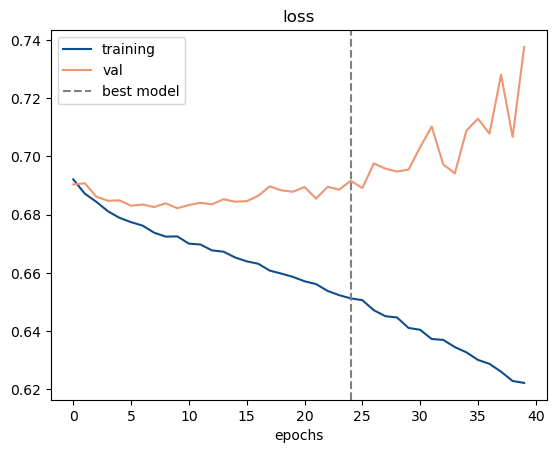

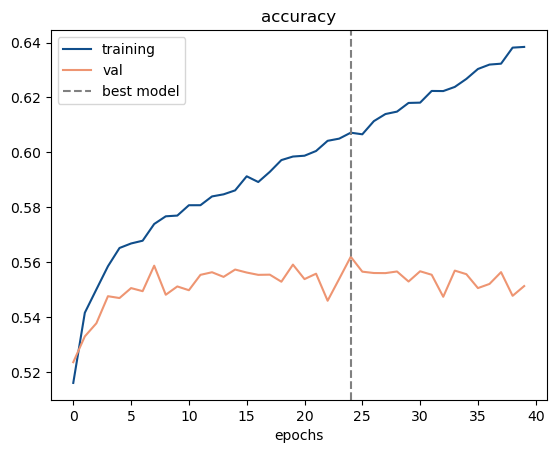

In [11]:
log = pd.read_json(Path(os.path.join(checkpoint_dir, 'log.txt')), lines=True)
best_model = np.argmax(log.test_accuracy)
for metric in ['loss', 'accuracy']:
    plot_logs(log, metric, best_model = best_model)

## Metrics

In [12]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    23827
1    20570
Name: prediction, dtype: int64


0    30197
1    14200
Name: ground_truth, dtype: int64


In [13]:
n_conf = 10

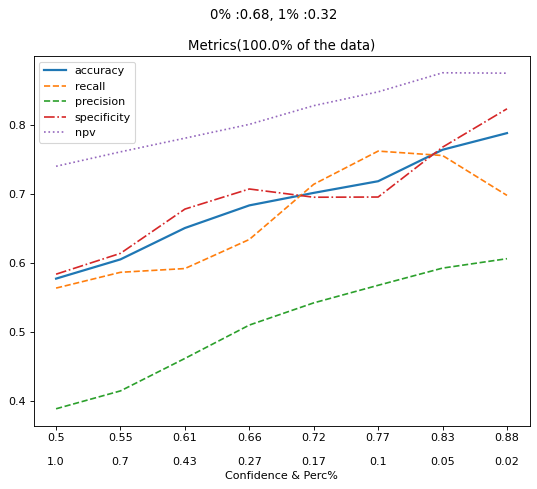

In [14]:
obtain_plot(res, n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

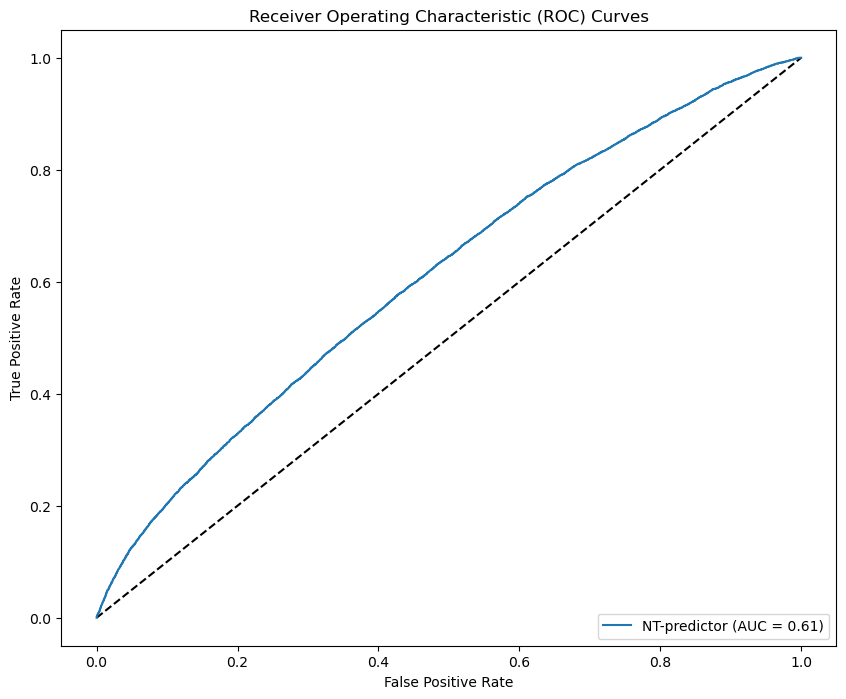

In [15]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT-predictor'}], res.ground_truth)

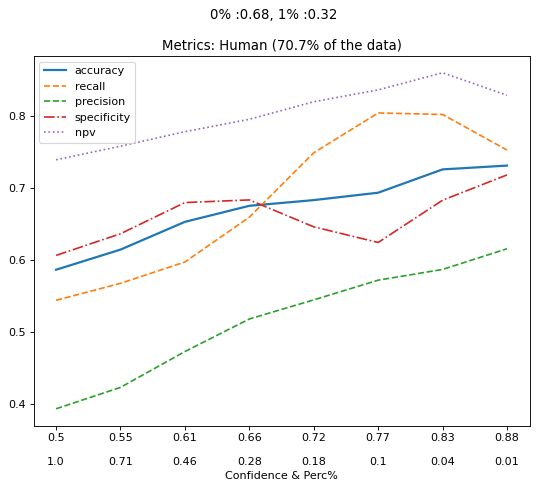

In [16]:
human = res[(res.specie == 'human')]
obtain_plot(human, n_original_df = res.shape[0], title = f'Metrics: Human ', n_conf = n_conf)

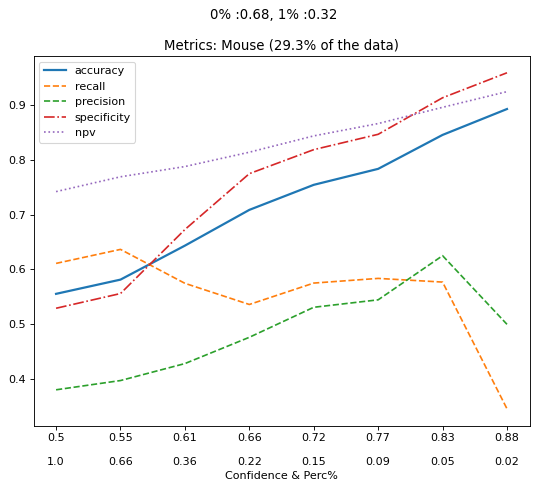

In [17]:
mouse = res[(res.specie == 'mouse')]
obtain_plot(mouse, n_original_df = res.shape[0], title = f'Metrics: Mouse ', n_conf = n_conf)

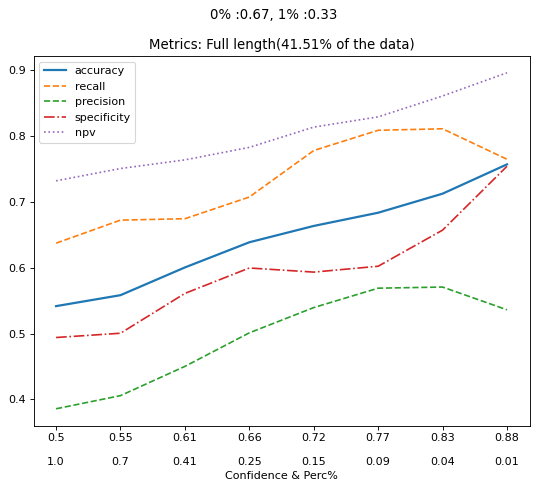

In [18]:
full_length = res[(res.original_length1 <= MAX_RNA_SIZE)&(res.original_length2 <= MAX_RNA_SIZE)]
obtain_plot(full_length, n_original_df = res.shape[0], title = f'Metrics: Full length', n_conf = 10)

In [19]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]

In [20]:
(high_conf_fl.ground_truth == high_conf_fl.prediction).sum() / high_conf_fl.shape[0]

0.631547969393761

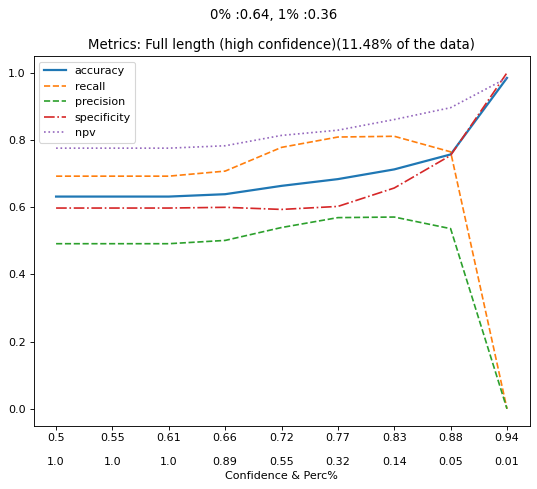

In [21]:
confidence_level = 0.65
high_conf_fl = full_length[(full_length.probability>confidence_level)|(full_length.probability<(1-confidence_level))]
obtain_plot(high_conf_fl, n_original_df = res.shape[0], title = f'Metrics: Full length (high confidence)', n_conf = n_conf)

In [22]:
# big_area_size = res.sampled_area.quantile(0.9)
# big_area_size = 5000**2
# big_area = res[res['sampled_area'] > big_area_size]

# obtain_plot(big_area, n_original_df = res.shape[0], title = f'Metrics: Big area', n_conf = n_conf)

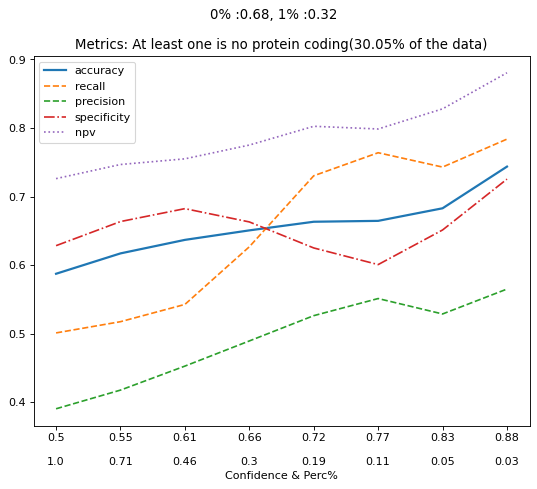

In [23]:
no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

obtain_plot(no_pc, n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

In [24]:
test = pd.read_csv(os.path.join(metadata_dir, f'val_sampled.csv'))
print(test.interacting.value_counts())
test = test[['id_gene1_sample', 'id_gene2_sample']]

True     14200
False    14200
Name: interacting, dtype: int64


In [25]:
res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

1    14212
0    14208
Name: ground_truth, dtype: int64

In [26]:
# subset_test_nt_sampled = os.path.join(rna_rna_files_dir, f"gene_pairs_val_sampled_nt.txt")
# with open(subset_test_nt_sampled, "rb") as fp:  # Unpickling
#     subset_test_nt_sampled = pickle.load(fp)
    
# easypos_smartneg = res[res.id_sample.isin(subset_test_nt_sampled)]

0.570478536242083


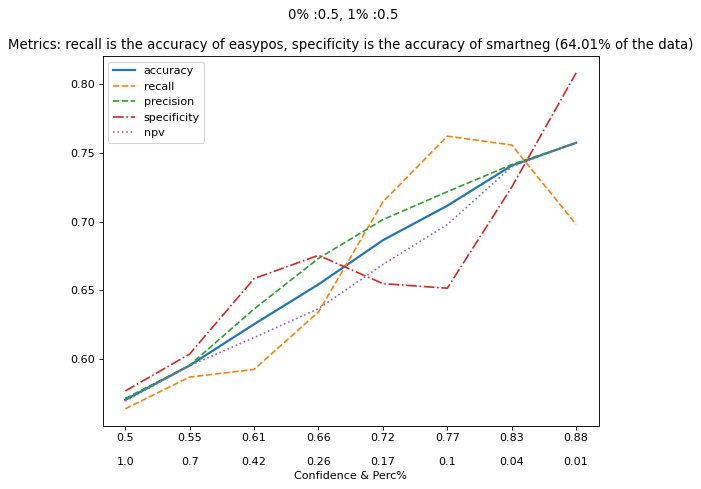

In [27]:
# vc = easypos_smartneg.ground_truth.value_counts()
# assert vc.loc[1] > vc.loc[0]
# n_to_exclude = vc.loc[1] - vc.loc[0]
# easypos_gt = easypos_smartneg[easypos_smartneg.ground_truth==1]
# id_to_exclude = list(easypos_gt.sample(frac = 1).head(n_to_exclude).id_sample)
# easypos_smartneg_sampled = easypos_smartneg[~easypos_smartneg.id_sample.isin(id_to_exclude)]

easypos_smartneg_sampled = easypos_smartneg
print((easypos_smartneg_sampled.prediction == easypos_smartneg_sampled.ground_truth).sum()/easypos_smartneg_sampled.shape[0])
obtain_plot(easypos_smartneg_sampled, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)

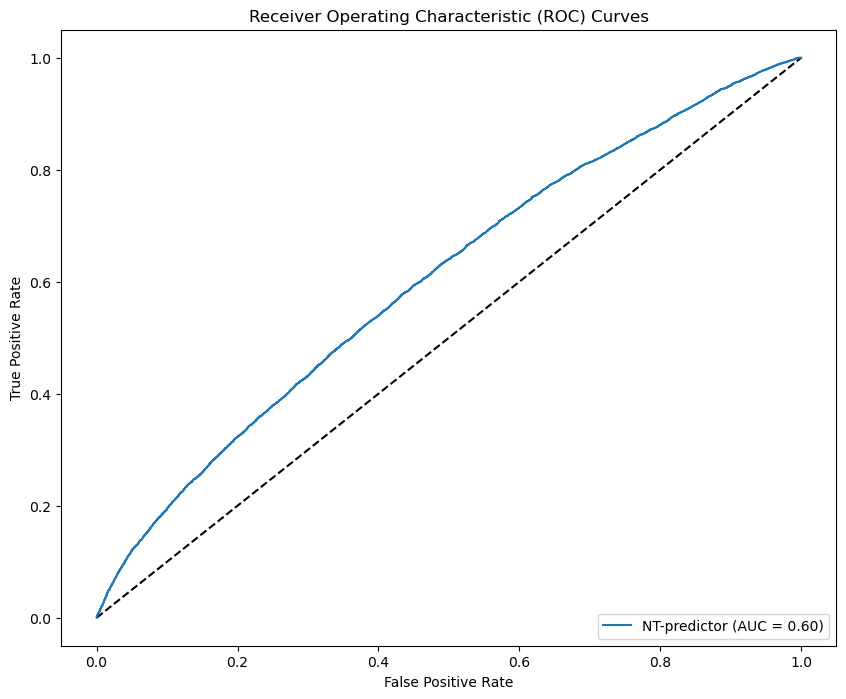

In [28]:
plot_roc_curves([{'prob': easypos_smartneg_sampled.probability, 'model_name': 'NT-predictor'}], easypos_smartneg_sampled.ground_truth)

0.75303197353914


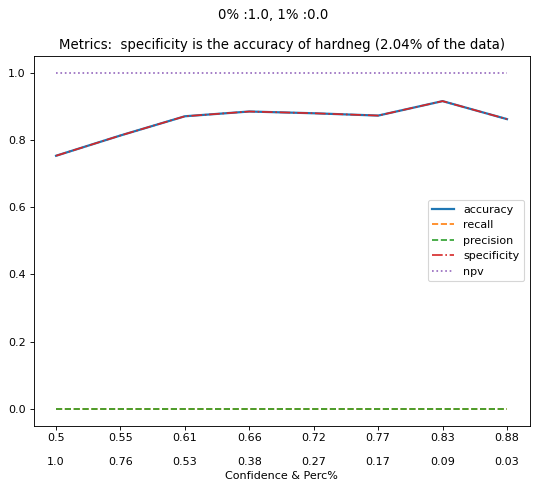

In [29]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.7773000859845228


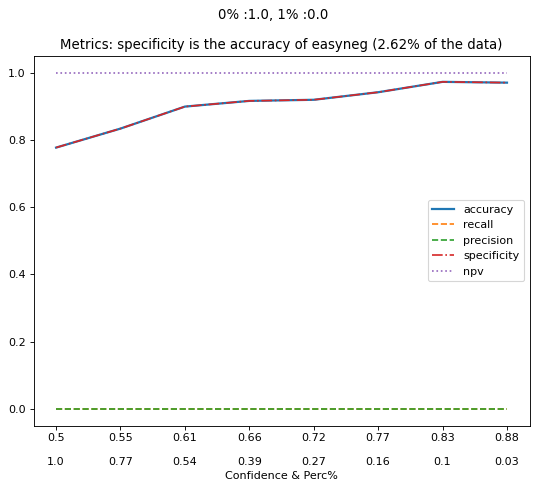

In [30]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

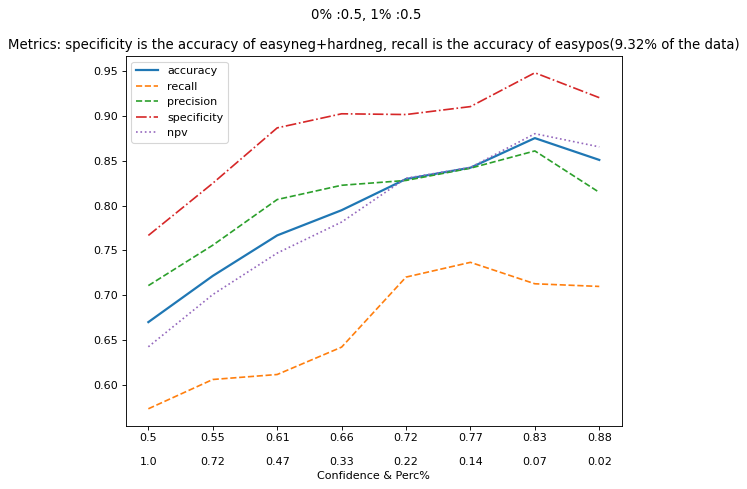

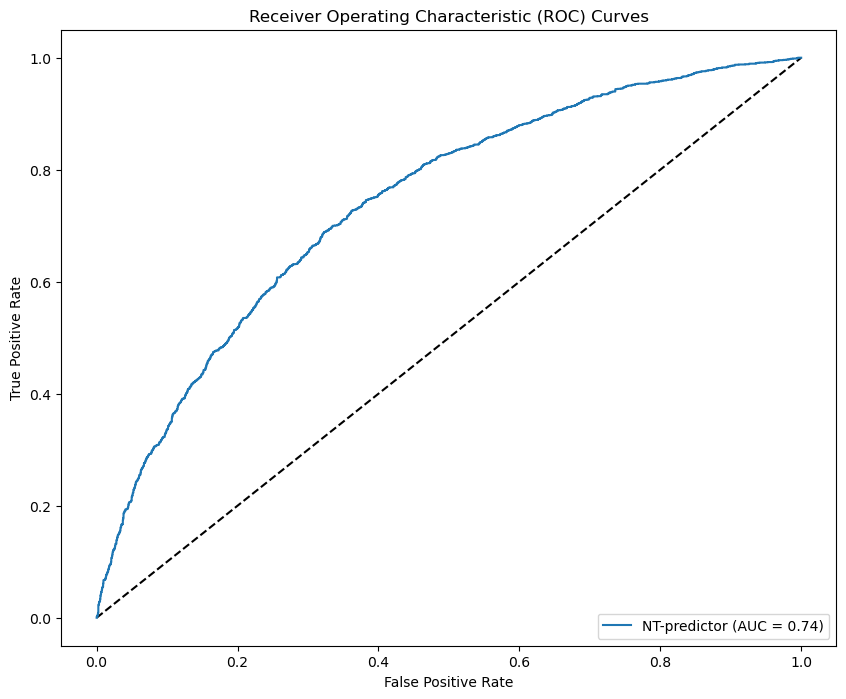

In [31]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT-predictor'}], ephnen_sampled.ground_truth)

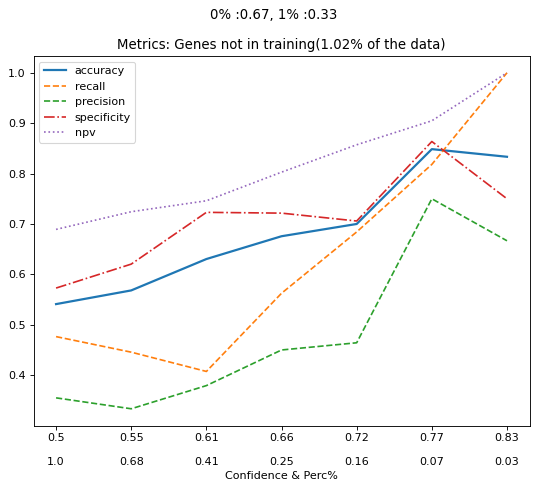

In [32]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

not_in_train = res[~(res.gene1_original.isin(df_train_genes) | res.gene2_original.isin(df_train_genes))]

obtain_plot(not_in_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training', n_conf = n_conf)

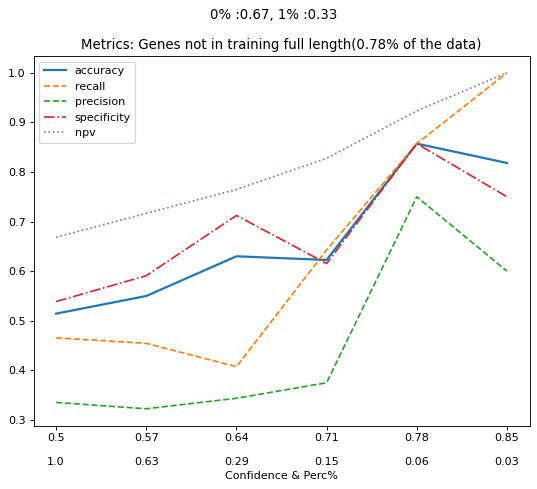

In [33]:
not_in_train_fl = not_in_train[(not_in_train.original_length1 <= MAX_RNA_SIZE)&(not_in_train.original_length2 <= MAX_RNA_SIZE)]
not_in_train_fl = not_in_train_fl[(not_in_train_fl.policy == 'easypos')|(not_in_train_fl.policy == 'smartneg')]
obtain_plot(not_in_train_fl, n_original_df = res.shape[0], title = f'Metrics: Genes not in training full length', n_conf = 8)

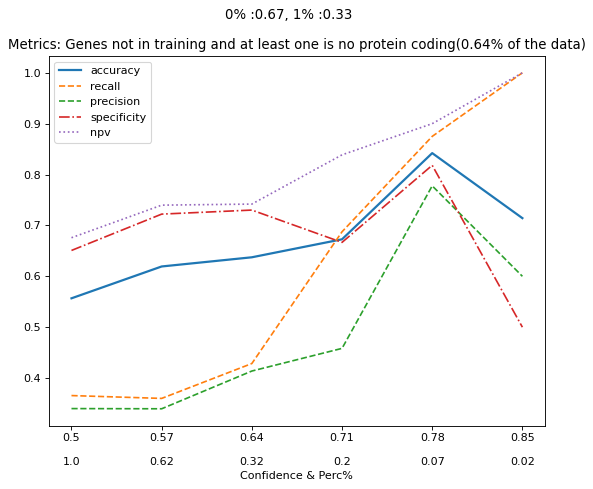

In [34]:
no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]

obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding', n_conf = 8)

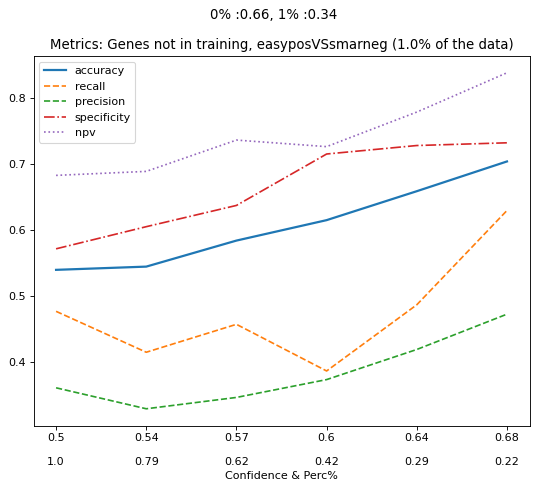

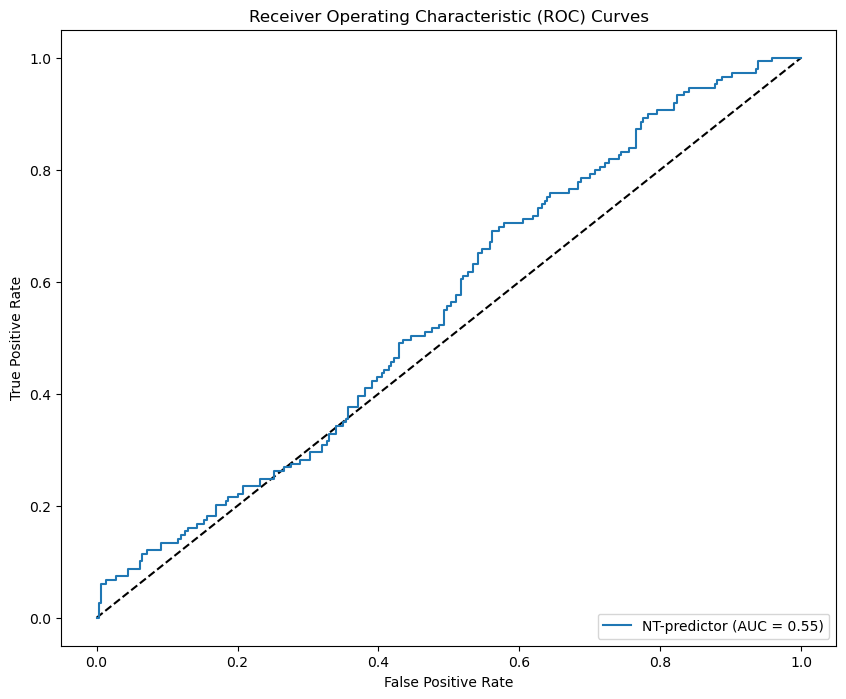

In [36]:
not_in_train_epsn = not_in_train[(not_in_train.policy == 'easypos')|(not_in_train.policy == 'smartneg')]
obtain_plot(not_in_train_epsn, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn.ground_truth)

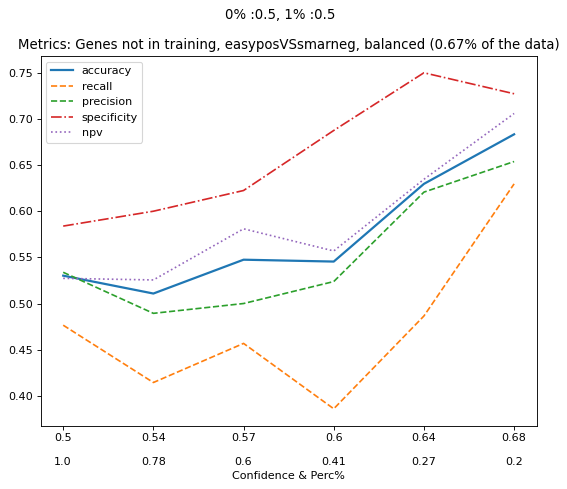

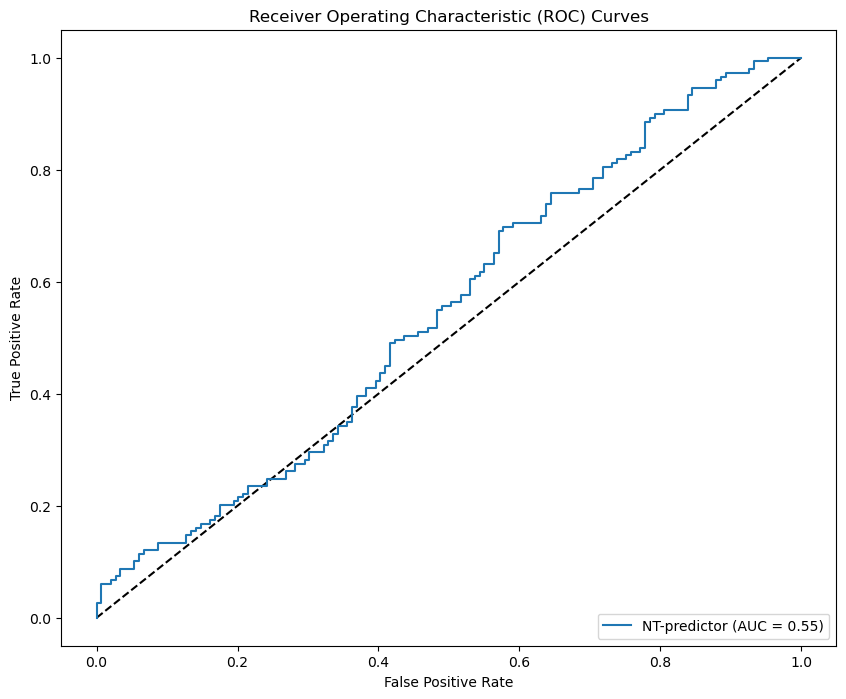

In [37]:
negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

not_in_train_epsn_balanced = pd.concat([negs.sample(len(poss)), poss], axis = 0)
obtain_plot(not_in_train_epsn_balanced, n_original_df = res.shape[0], title = f'Metrics: Genes not in training, easyposVSsmarneg, balanced ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': not_in_train_epsn_balanced.probability, 'model_name': 'NT-predictor'}], not_in_train_epsn_balanced.ground_truth)

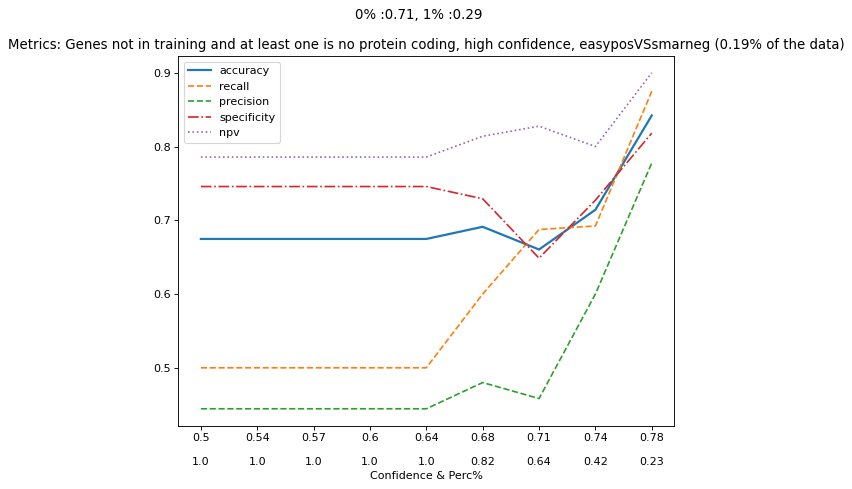

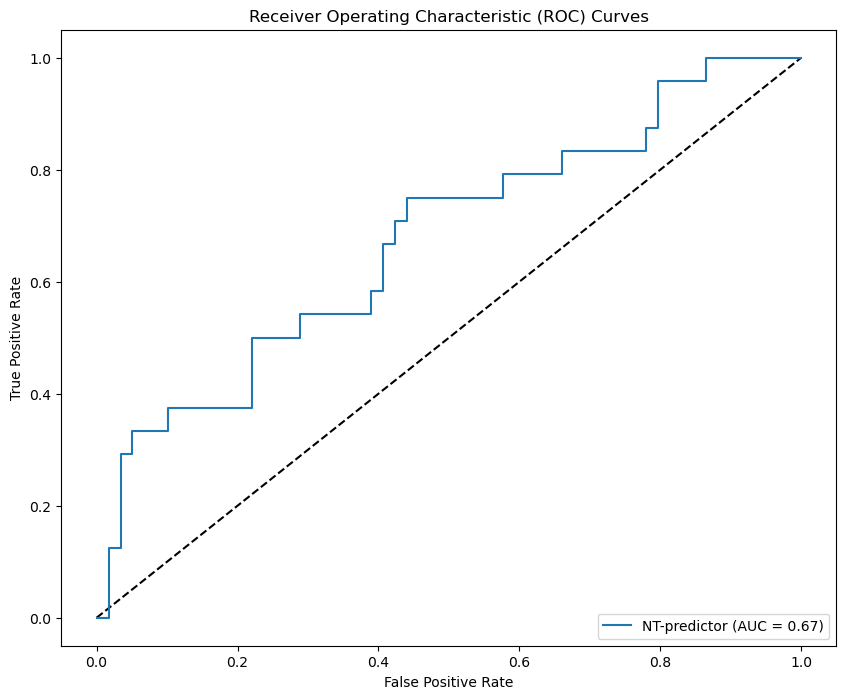

In [38]:
confidence_level = 0.65

no_pc_no_train = not_in_train[(not_in_train['gene1_pc'] == False)|(not_in_train['gene2_pc'] == False)]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.probability>confidence_level)|(no_pc_no_train.probability<(1-confidence_level))]
no_pc_no_train = no_pc_no_train[(no_pc_no_train.policy == 'easypos')|(no_pc_no_train.policy == 'smartneg')]
obtain_plot(no_pc_no_train, n_original_df = res.shape[0], title = f'Metrics: Genes not in training and at least one is no protein coding, high confidence, easyposVSsmarneg ', n_conf = 15, excluding_treshold = 0.2)
plot_roc_curves([{'prob': no_pc_no_train.probability, 'model_name': 'NT-predictor'}], no_pc_no_train.ground_truth)

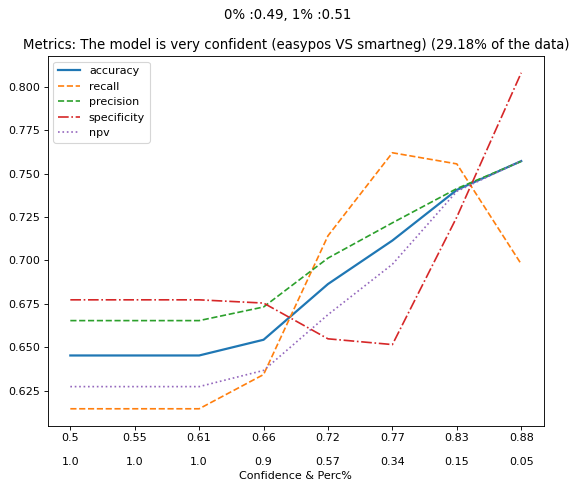

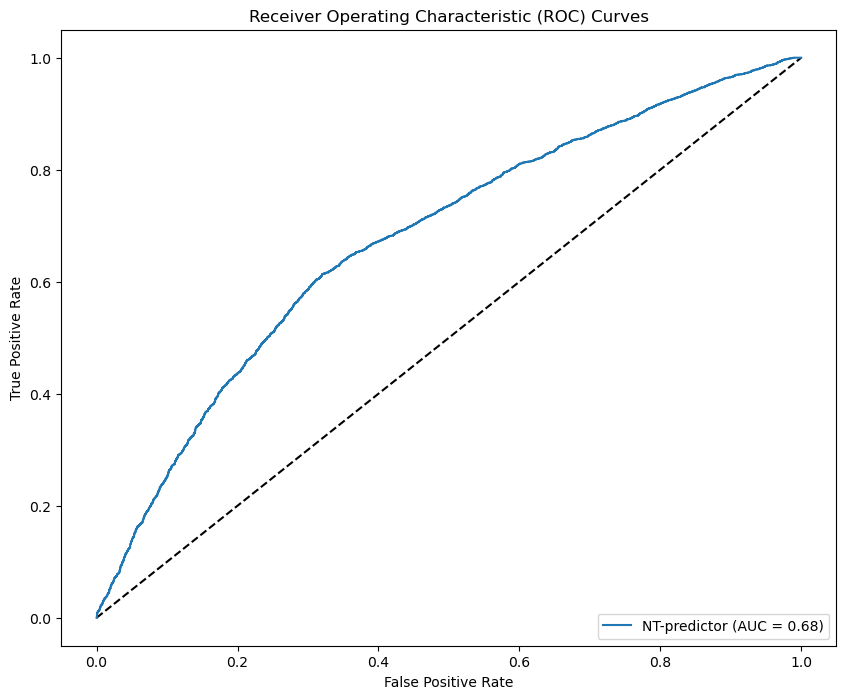

In [39]:
confidence_level = 0.65
high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

obtain_plot(high_prob_pairs, n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

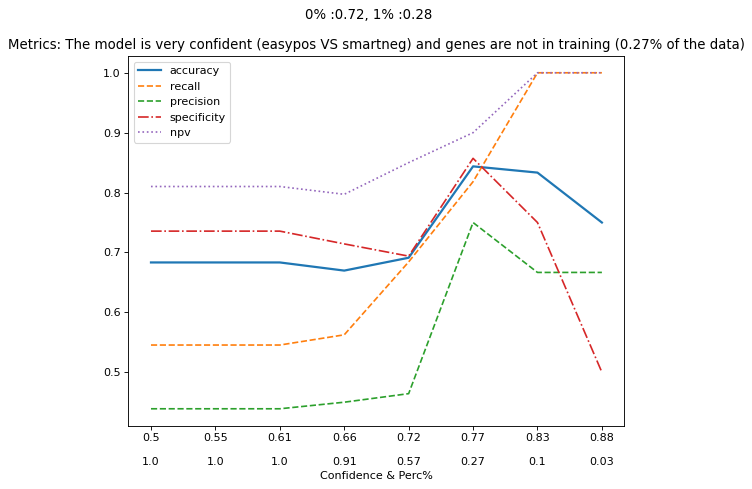

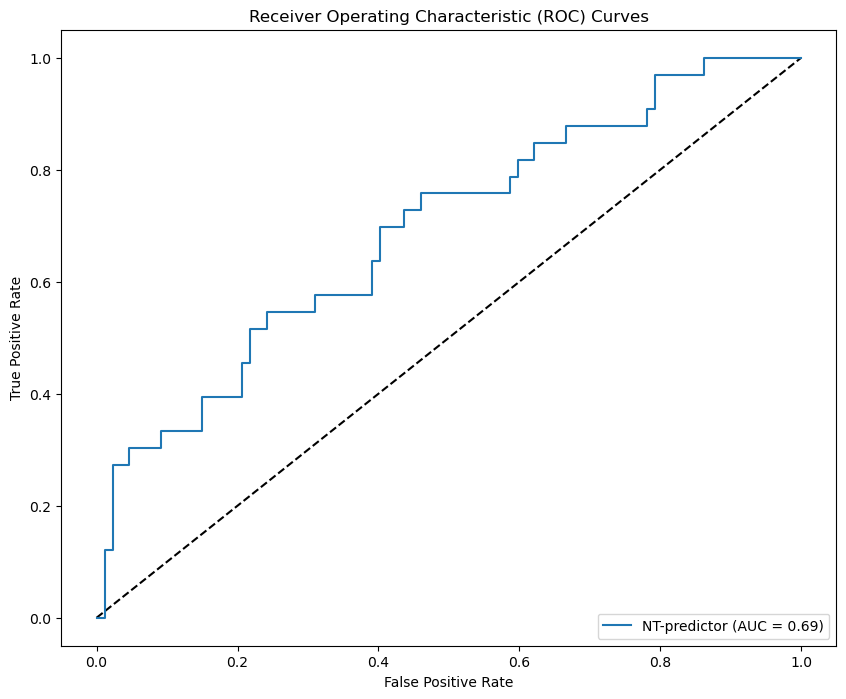

In [40]:
confidence_level = 0.65
high_prob_pairs = not_in_train[(not_in_train.probability>confidence_level)|(not_in_train.probability<(1-confidence_level))]
high_prob_pairs = high_prob_pairs[(high_prob_pairs.policy == 'easypos')|(high_prob_pairs.policy == 'smartneg')]

obtain_plot(high_prob_pairs, n_original_df = res.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) and genes are not in training ', n_conf = n_conf)
plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

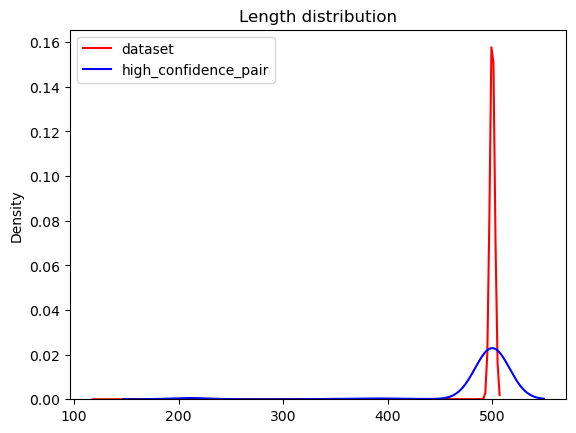

In [41]:
sns.kdeplot(list(pd.concat([easypos_smartneg.len_g1, easypos_smartneg.len_g2], axis = 0)), color = 'red', label = 'dataset')
sns.kdeplot(list(pd.concat([high_prob_pairs.len_g1, high_prob_pairs.len_g2], axis = 0)), color = 'blue', label = 'high_confidence_pair')
plt.title(f'Length distribution')
plt.legend()

# Compare with INTARNA

In [42]:
intarna = pd.read_csv(os.path.join(intarna_dir, 'val500', 'val.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

In [43]:
res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [44]:
intarna.shape[0]

44397

In [45]:
res.shape[0]

44397

In [46]:
auc_nt = []
auc_intarna = []

for i in range(500):
    # undersample 0 class
    res0 = res[res.ground_truth == 0]
    res1 = res[res.ground_truth == 1]
    balanced = pd.concat([res0.sample(res1.shape[0]), res1], axis = 0)

    fpr, tpr, _ = roc_curve(balanced.ground_truth, balanced.probability)
    roc_auc = auc(fpr, tpr)
    auc_nt.append(roc_auc)
    
    fpr, tpr, _ = roc_curve(abs(1 - balanced.ground_truth), balanced.E_norm)
    roc_auc = auc(fpr, tpr)
    auc_intarna.append(roc_auc)

In [47]:
print(np.mean(auc_nt), 
      np.mean(auc_intarna)
     )

0.6099939189992065 0.5340986564669709


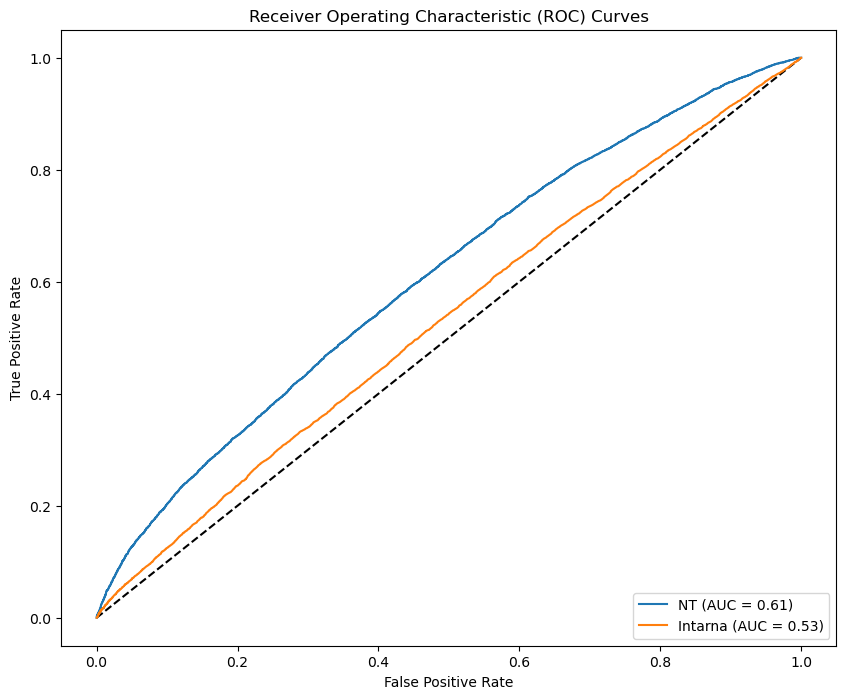

In [48]:
plot_roc_curves([{'prob': balanced.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced.E_norm), 'model_name': 'Intarna'}
                ], balanced.ground_truth)

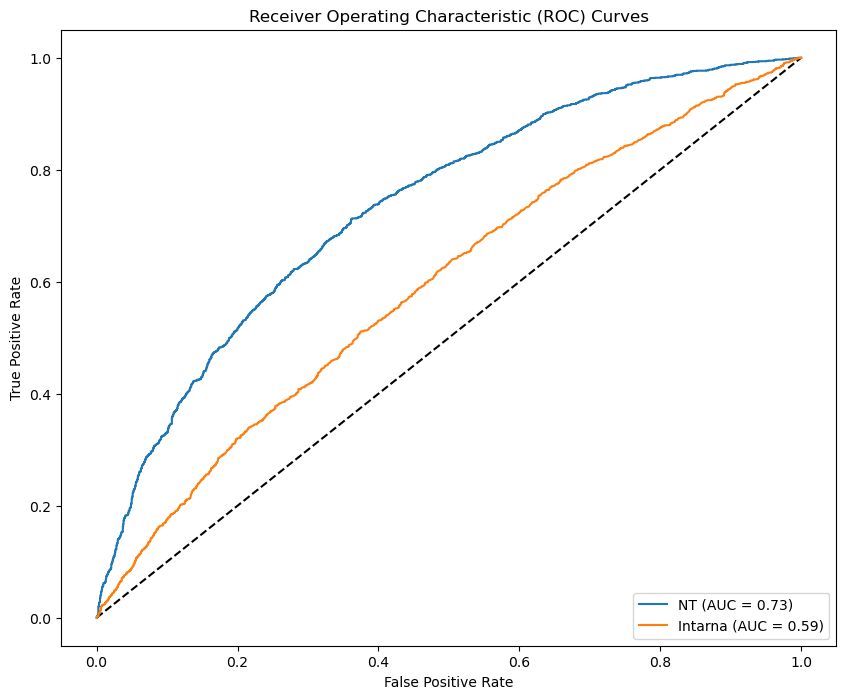

In [49]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

vc = ephnen.ground_truth.value_counts()
assert vc.loc[1] > vc.loc[0]
n_to_exclude = vc.loc[1] - vc.loc[0]
ephnen_gt = ephnen[ephnen.ground_truth==1]
id_to_exclude = list(ephnen_gt.sample(frac = 1).head(n_to_exclude).id_sample)
ephnen_sampled = ephnen[~ephnen.id_sample.isin(id_to_exclude)]

plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

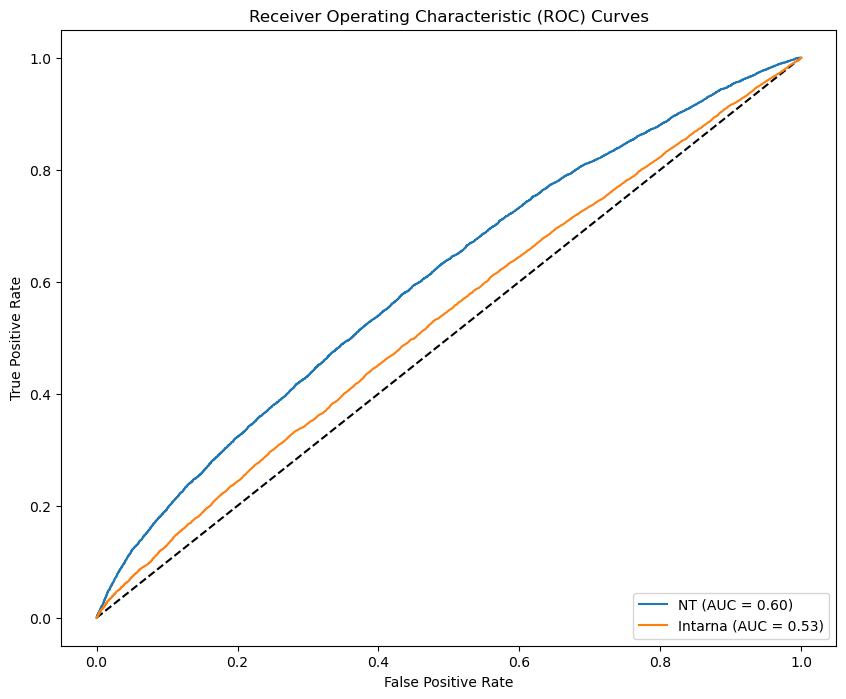

In [50]:
test = pd.read_csv(os.path.join(metadata_dir, f'val_sampled.csv'))
test = test[['id_gene1_sample', 'id_gene2_sample']]

res1 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene1_sample', 'id_gene2_sample'])
res2 = res.merge(test, left_on = ['g1', 'g2'], right_on = ['id_gene2_sample', 'id_gene1_sample'])
easypos_smartneg = pd.concat([res1, res2], axis = 0)
easypos_smartneg.ground_truth.value_counts()

plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


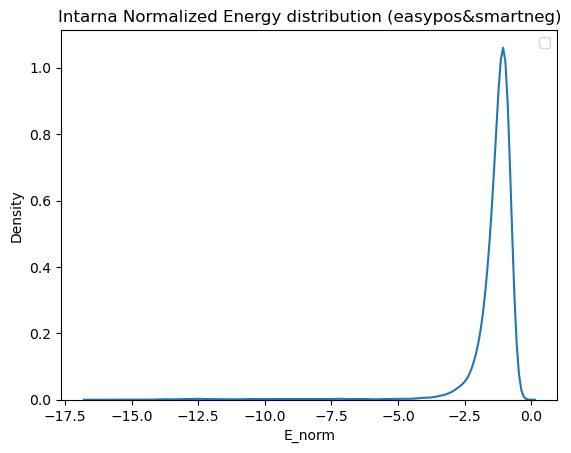

In [51]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

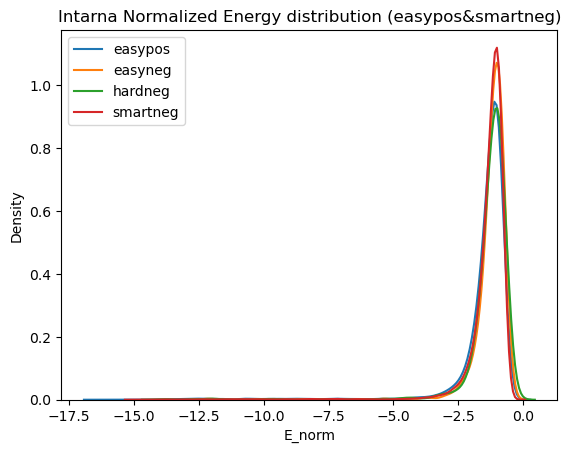

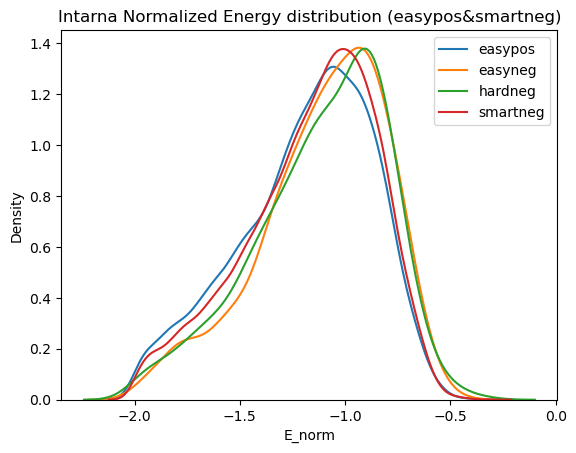

In [52]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [53]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  2.0 %


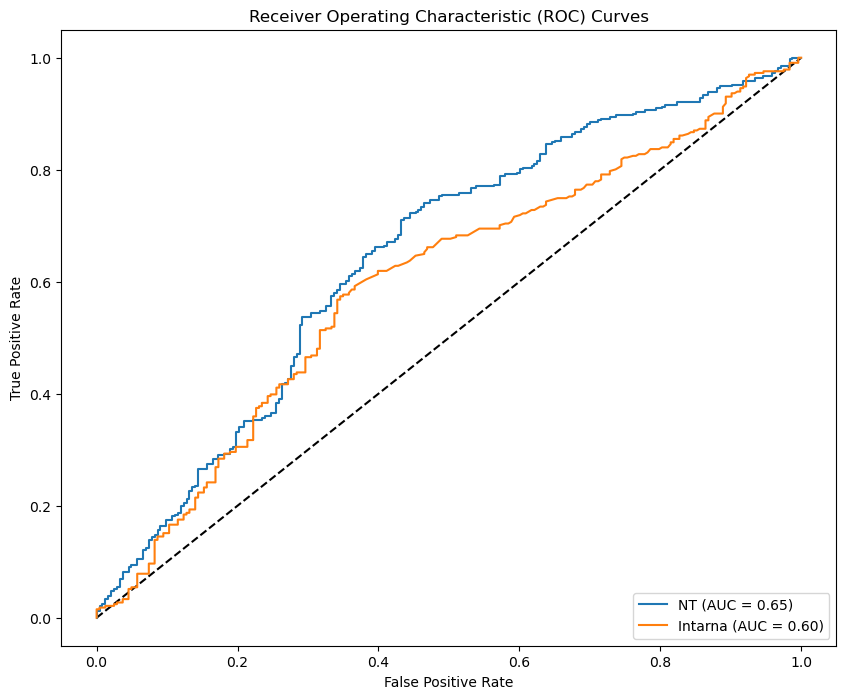

In [54]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.01)

perc of the total data:  19.5 %


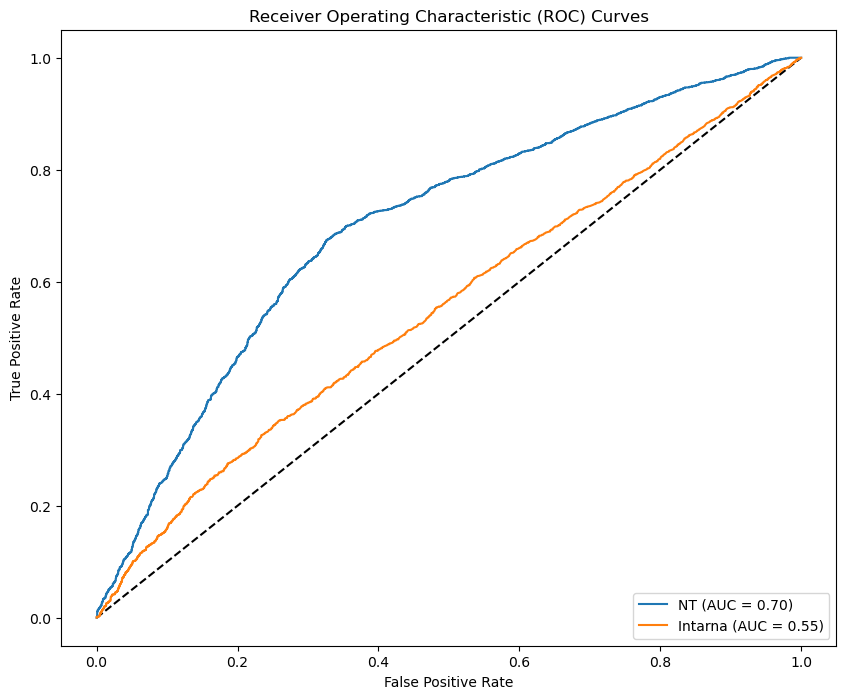

In [55]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Confidence & Perc%')

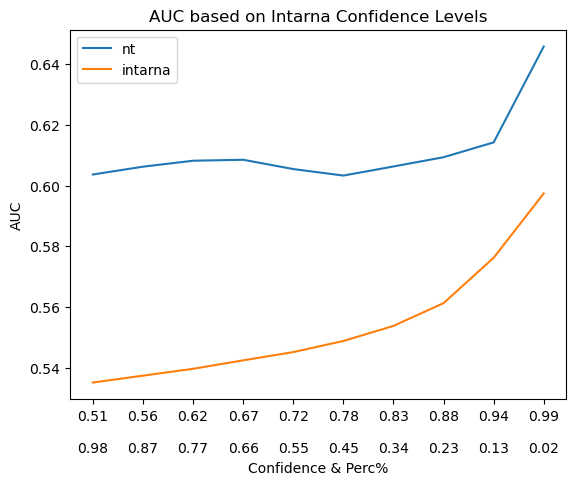

In [56]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

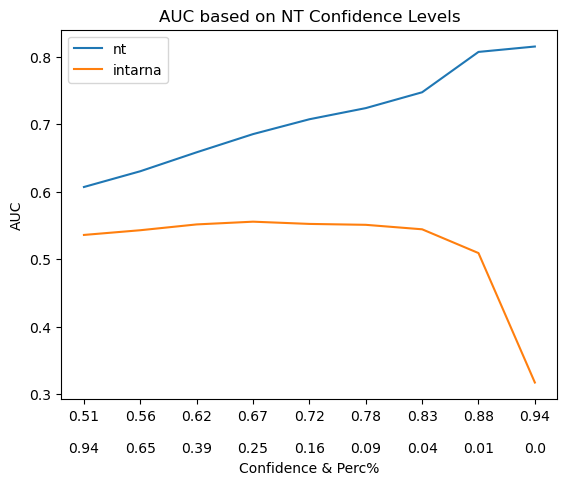

In [57]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

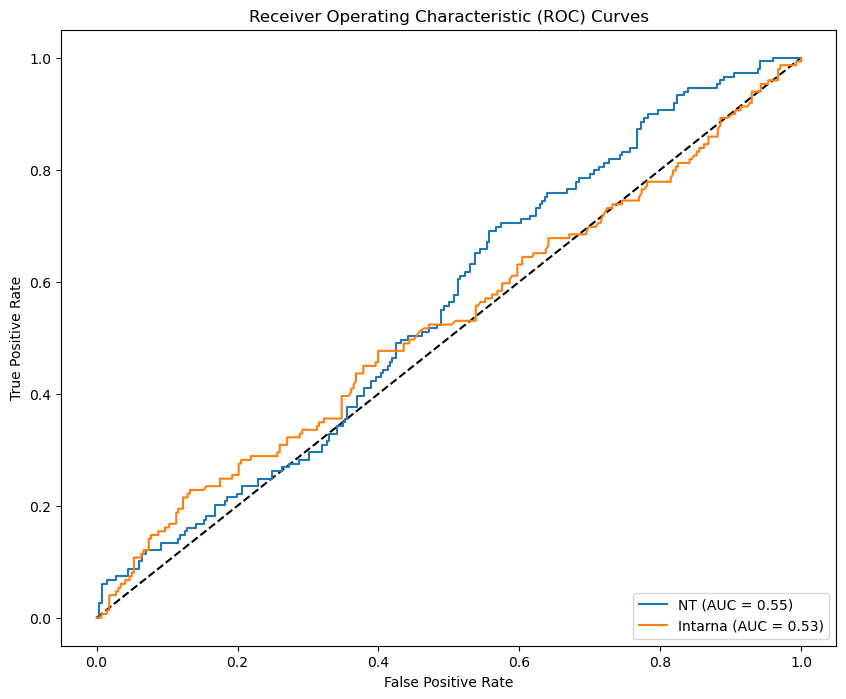

In [58]:
n_iters = 100

lists = []

for i in range(n_iters):

    not_in_train_epsn = easypos_smartneg[~(easypos_smartneg.gene1_original.isin(df_train_genes) | easypos_smartneg.gene2_original.isin(df_train_genes))]

    negs = not_in_train_epsn[not_in_train_epsn.ground_truth == 0]
    poss = not_in_train_epsn[not_in_train_epsn.ground_truth == 1]

    not_in_train_epsn = pd.concat([negs.sample(len(poss)), poss], axis = 0)
    lists.append(not_in_train_epsn)

not_in_train_epsn = pd.concat(lists, axis = 0)

plot_roc_curves([{'prob': not_in_train_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(not_in_train_epsn.E_norm), 'model_name': 'Intarna'}
                ], not_in_train_epsn.ground_truth)

In [59]:
treshold = 0.7
subset_where_disagree = easypos_smartneg[
                (easypos_smartneg.probability >= treshold)|
                (easypos_smartneg.probability <= (1-treshold))
            ]

In [60]:
subset_where_disagree.ground_truth.value_counts()

1    2885
0    2650
Name: ground_truth, dtype: int64

# Estimate bias due to genes degree

In [61]:
df_nt_train = df_nt[df_nt.couples.isin(gene_pairs_train)]

In [62]:
def obtain_gene_count_real(df):
    vc = df.interacting.value_counts()
    if set(vc.index) == {False, True}:
        unbalance_factor = vc[True]/vc[False]
    else:
        unbalance_factor = np.nan
    gene_count_pos_list = list(df[df.interacting].gene1) + list(df[df.interacting].gene2)
    gene_count_neg_list = list(df[df.interacting == False].gene1) + list(df[df.interacting == False].gene2)

    gene_count_pos = pd.DataFrame({'gene': gene_count_pos_list, 'interacting':1})
    gene_count_neg = pd.DataFrame({'gene': gene_count_neg_list, 'interacting':0})
    gene_count_res = pd.concat([gene_count_pos, gene_count_neg], axis = 0)
    
    gene_count_res['weight'] = 1
    gene_count_res.loc[ gene_count_res.interacting == 0, 'weight'] = unbalance_factor
    gene_count_real = gene_count_res.groupby('gene').sum()
    gene_count_real['not_interacting'] = gene_count_real['weight'] - gene_count_real['interacting']
    gene_count_real['diff'] = gene_count_real['interacting'] - gene_count_real['not_interacting']
    gene_count_real['total'] = gene_count_real['not_interacting'] + gene_count_real['interacting']
    gene_count_real = gene_count_real.reset_index()#add gene column
    return gene_count_real

In [63]:
gene_count_train = obtain_gene_count_real(df_nt_train)

In [64]:
perc_list = []
pred_bias_list = []
acc_bias_list = []
diff_tresholds = np.linspace(0, 300, 10)
for diff_treshold in diff_tresholds:
    bias = res.merge(gene_count_train[['gene', 'diff']], how = 'left', left_on = 'g1', right_on = 'gene').rename({'diff':'diff1'}, axis = 1).drop('gene', axis = 1)
    bias = bias.merge(gene_count_train[['gene', 'diff']], how = 'left', left_on = 'g2', right_on = 'gene').rename({'diff':'diff2'}, axis = 1).drop('gene', axis = 1)
    bias = bias.fillna(0)   
    bias['diff_sum'] = bias['diff1'] + bias['diff2']
    bias['diff_sign'] = (bias['diff_sum'] > 0).astype(int)
    bias = bias[(bias['diff_sum'] > diff_treshold)|(bias['diff_sum'] <-diff_treshold)]

    perc = np.round(bias.shape[0]/res.shape[0] * 100, 2)
    pred_bias = (bias.prediction == bias['diff_sign']).sum()/bias.shape[0] * 100
    pred_bias = np.round(pred_bias, 2)
    acc_bias = (bias.prediction == bias.ground_truth).sum()/bias.shape[0] * 100
    acc_bias = np.round(acc_bias, 2)
    print(f'in the {perc}% of the data, the prediction equal to the sum of sign is {pred_bias} %, and the accuracy of those predictions is {acc_bias}%')
    perc_list.append(perc)
    pred_bias_list.append(pred_bias)
    acc_bias_list.append(acc_bias)

in the 77.05% of the data, the prediction equal to the sum of sign is 53.64 %, and the accuracy of those predictions is 56.57%
in the 5.3% of the data, the prediction equal to the sum of sign is 69.77 %, and the accuracy of those predictions is 57.88%
in the 4.35% of the data, the prediction equal to the sum of sign is 69.93 %, and the accuracy of those predictions is 56.57%
in the 1.1% of the data, the prediction equal to the sum of sign is 89.32 %, and the accuracy of those predictions is 67.35%
in the 0.65% of the data, the prediction equal to the sum of sign is 90.62 %, and the accuracy of those predictions is 70.83%
in the 0.59% of the data, the prediction equal to the sum of sign is 90.42 %, and the accuracy of those predictions is 69.35%
in the 0.59% of the data, the prediction equal to the sum of sign is 90.42 %, and the accuracy of those predictions is 69.35%
in the 0.59% of the data, the prediction equal to the sum of sign is 90.42 %, and the accuracy of those predictions is 

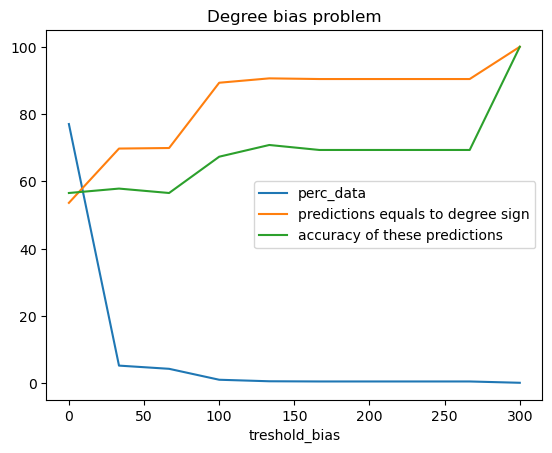

In [65]:
plt.title('Degree bias problem')
plt.plot(diff_tresholds, perc_list, label = 'perc_data')
plt.plot(diff_tresholds, pred_bias_list, label = 'predictions equals to degree sign')
plt.plot(diff_tresholds, acc_bias_list, label = 'accuracy of these predictions')
plt.xlabel('treshold_bias')
plt.legend()
plt.show()

In [66]:
diff_treshold = 5
genes_problematic_list = list(gene_count_train[(gene_count_train['diff'] > diff_treshold)|(gene_count_train['diff'] < -diff_treshold)].gene)

In [67]:
print('# of problematic genes: ', len(genes_problematic_list))

perc = np.round(res[(res.g1.isin(genes_problematic_list))|(res.g2.isin(genes_problematic_list))].shape[0]/res.shape[0] * 100, 2)

print('% of data affected from these genes: ', perc)

for problematic_gene in genes_problematic_list:
    gene_sign = bool(gene_count_train[gene_count_train.gene == problematic_gene]['diff'].iloc[0] > 0)
    bias = res[(res.g1 == problematic_gene)|(res.g2 == problematic_gene)]
    perc = np.round(bias.shape[0]/res.shape[0] * 100, 2)
    pred_bias = (bias.prediction == gene_sign).sum()/bias.shape[0] * 100
    pred_bias = np.round(pred_bias, 2)
    acc_bias = (bias.prediction == bias.ground_truth).sum()/bias.shape[0] * 100
    acc_bias = np.round(acc_bias, 2)
    if perc>0.9:
        print(f'in the {perc}% of the data, the prediction equal to the sum of sign is {pred_bias} %, and the accuracy of those predictions is {acc_bias}%')

# of problematic genes:  554
% of data affected from these genes:  13.7


/tmp/ipykernel_300746/3921201605.py:11: RuntimeWarning: invalid value encountered in long_scalars
  pred_bias = (bias.prediction == gene_sign).sum()/bias.shape[0] * 100
/tmp/ipykernel_300746/3921201605.py:13: RuntimeWarning: invalid value encountered in long_scalars
  acc_bias = (bias.prediction == bias.ground_truth).sum()/bias.shape[0] * 100


in the 2.1% of the data, the prediction equal to the sum of sign is 77.79 %, and the accuracy of those predictions is 60.84%
in the 1.08% of the data, the prediction equal to the sum of sign is 33.47 %, and the accuracy of those predictions is 34.51%
in the 0.96% of the data, the prediction equal to the sum of sign is 88.99 %, and the accuracy of those predictions is 57.38%


# XAI

In [68]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

/data01/giorgio/ENTER/envs/rnarna/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


BinaryClassifierNT(
  (nt_projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 0, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (top_classifier): MLP(
    (input_layer): Sequential(
      (0): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=5120, out_features=256, bias=True)
    )
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=328, bias=True)
    )
    (output_layer): Linear(in_features=328, out_features=400, bias=True)
    (activation_functions): ModuleList(
      (0): Tanh()
      (1): ReLU()
    )
    (dropout_layers): ModuleList(
      (0-1): 2 x Dropout(p=0.01, inplace=False)
    )
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(400, 256, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=

In [69]:
xai = pd.read_csv(os.path.join(checkpoint_dir, 'gradcam_results500.csv'))

In [70]:
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [71]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0071
iou_value_tr: 0.0065
iou_value_rand: 0.0031


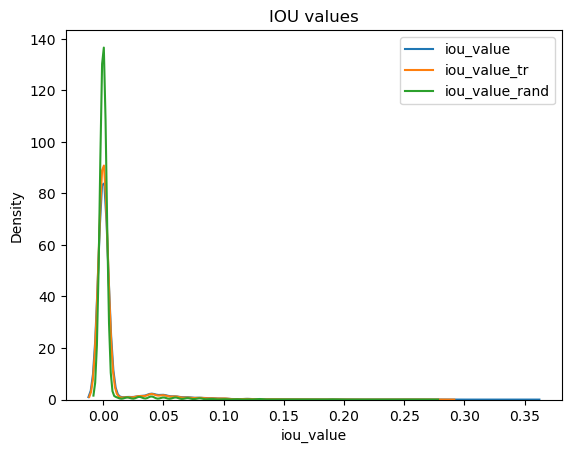

intensity: 0.4165
intensity_tr: 0.1477
intensity_rand: 0.5


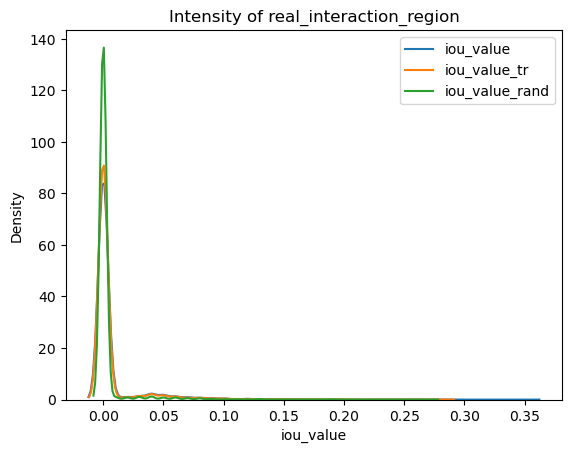

euclidean: 0.4617
euclidean_rand: 0.5286
euclidean_bbox_tr: 0.4753


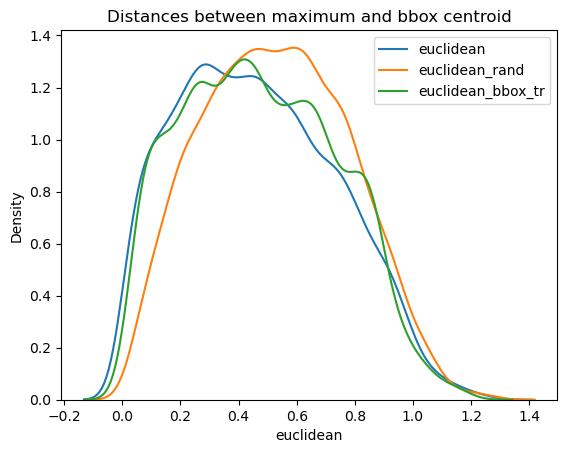

cos_sim: 0.06
cos_sim_tr: 0.04
cos_sim_rand: 0.04


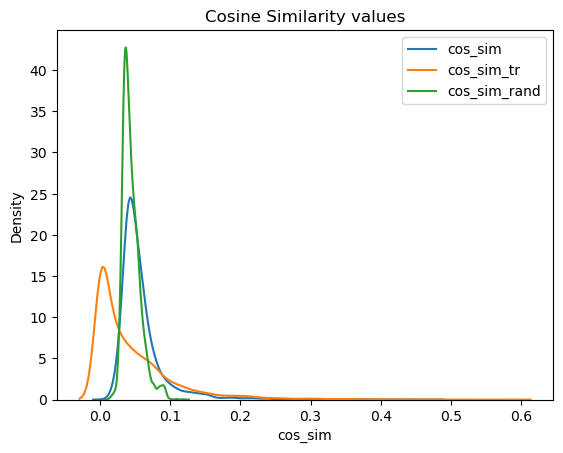

In [72]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

In [73]:
df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
regex = df_nt[df_nt.couples.isin(gene_pairs_train)].couples_id.str.extractall('(.*)_(.*)').reset_index()
df_train = regex
df_train['g1'] = regex[0]
df_train['g2'] = regex[1]
df_train_genes = set(df_train['g1']).union(set(df_train['g2']))

euclidean: 0.2918
euclidean_rand: 0.7493


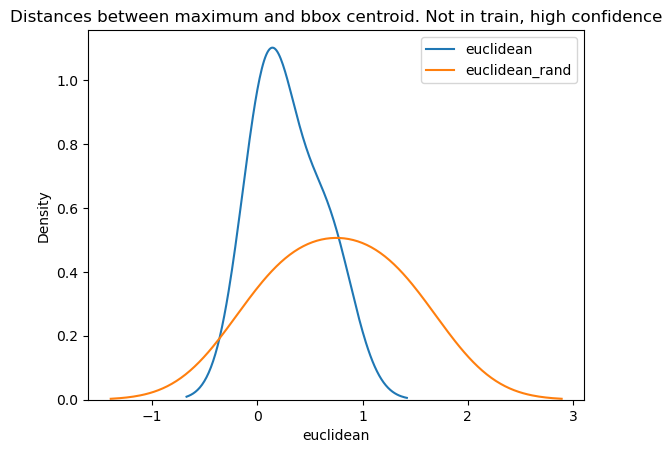

In [17]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.65)&(gradcam_results.probability<0.8)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. Not in train, high confidence')
plt.legend()
plt.show()

In [74]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

euclidean: 0.3669
euclidean_rand: 0.5276


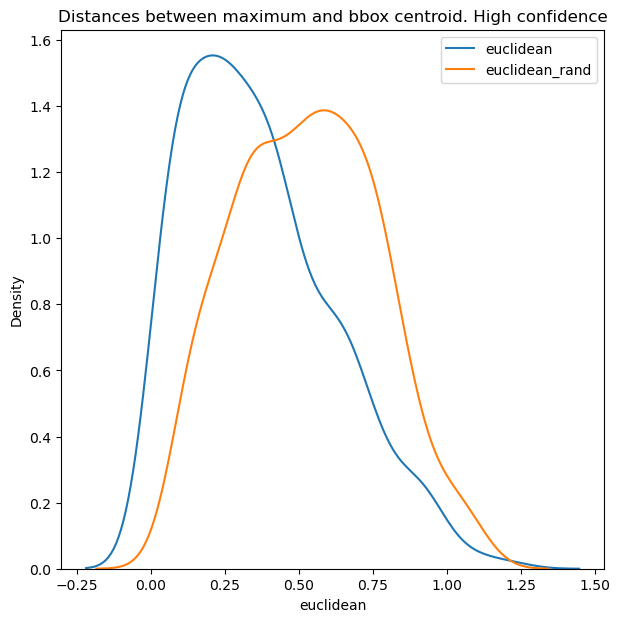

In [80]:
gradcam_results = xai[(xai.probability>0.75)&(xai.probability<0.79)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()

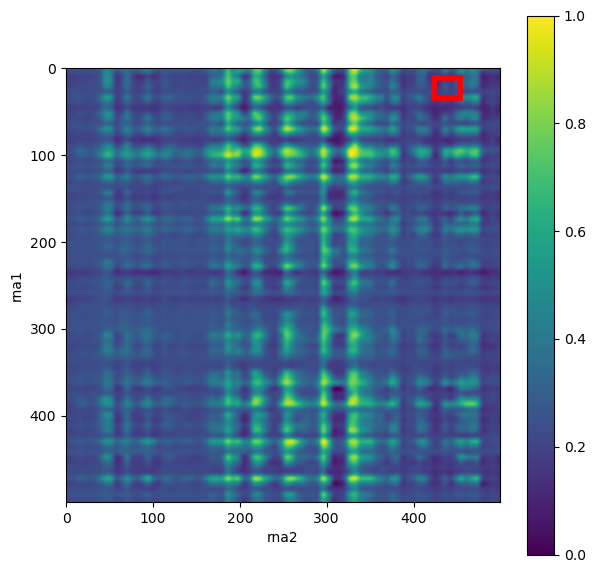

In [81]:
query = test500[test500.couples.isin(list(gradcam_results.id))]
plot_query_results(query.sample(1))

Not in training

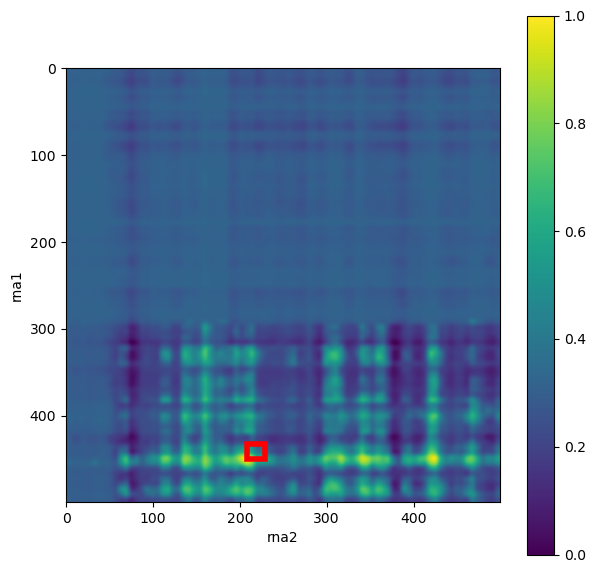

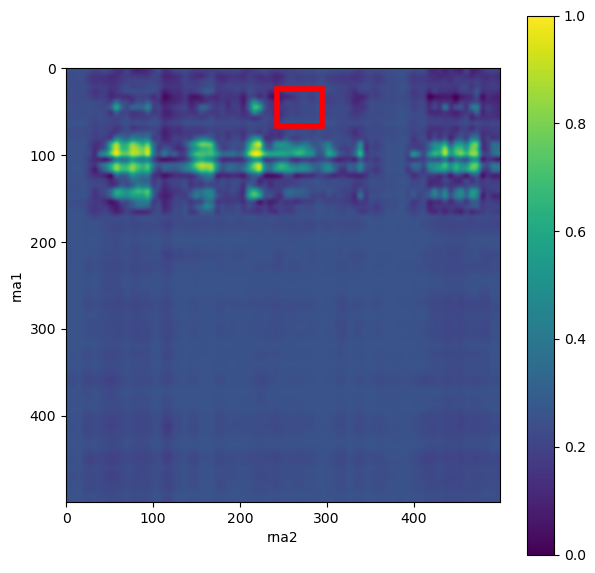

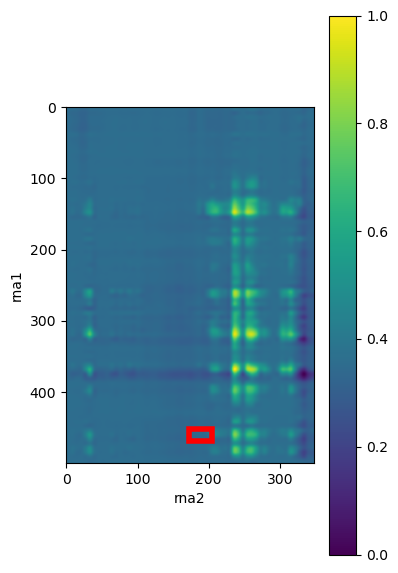

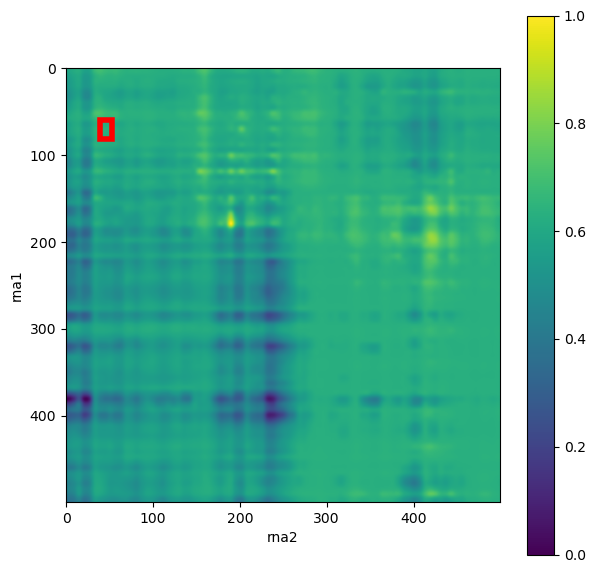

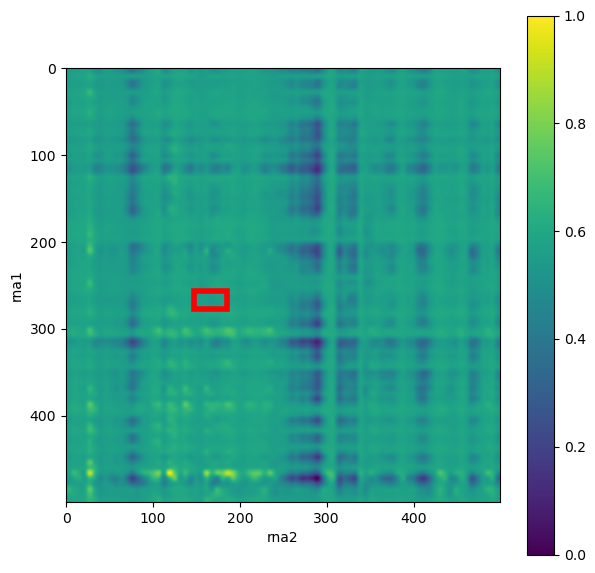

In [94]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.sample(5))

High confidence not in train

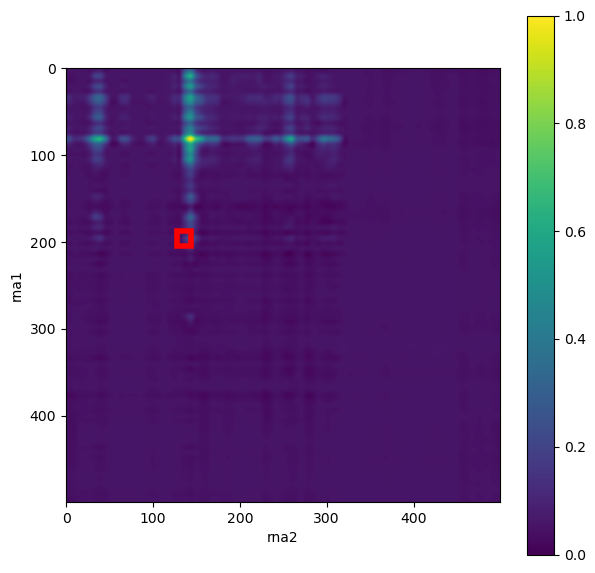

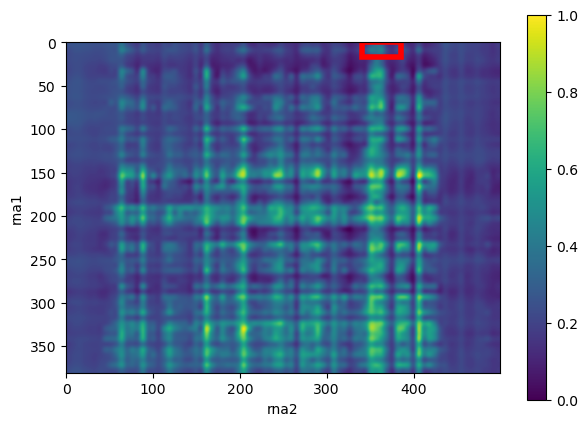

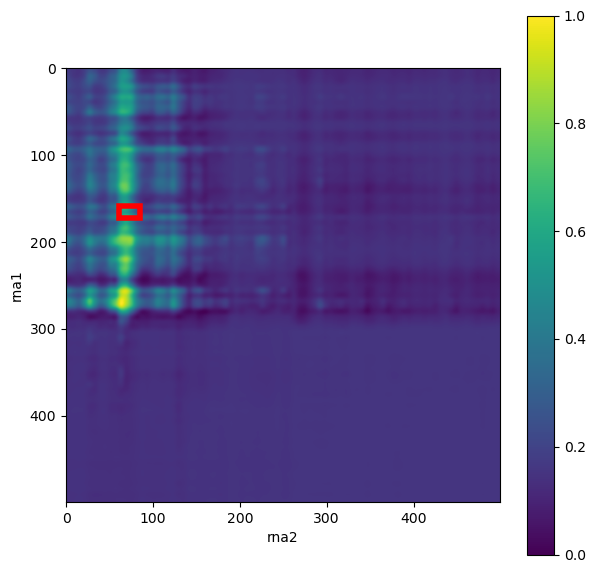

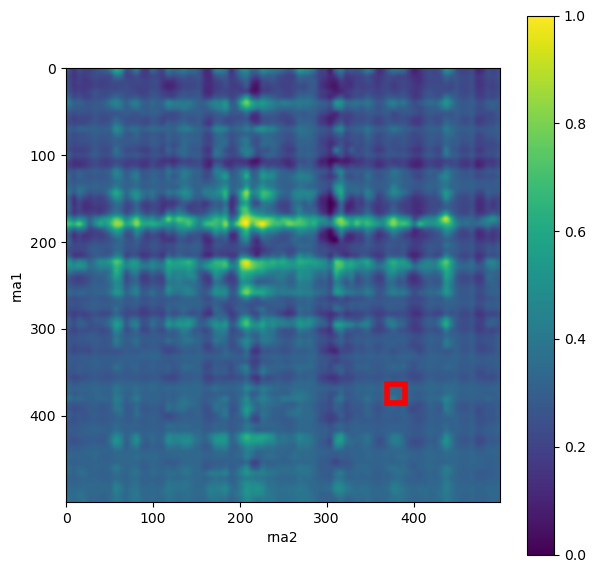

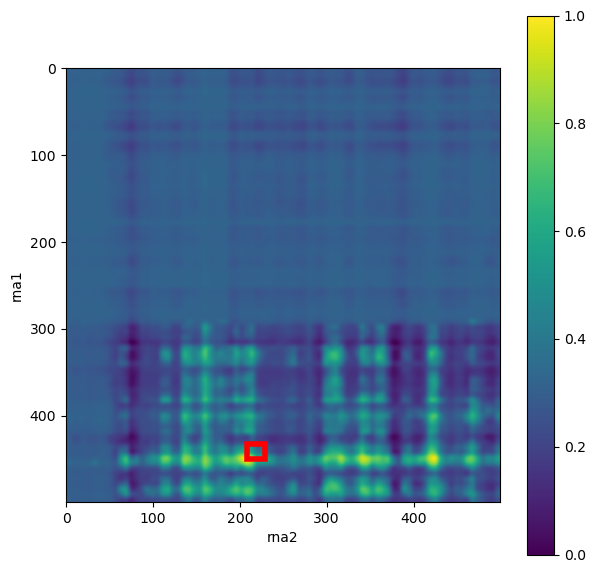

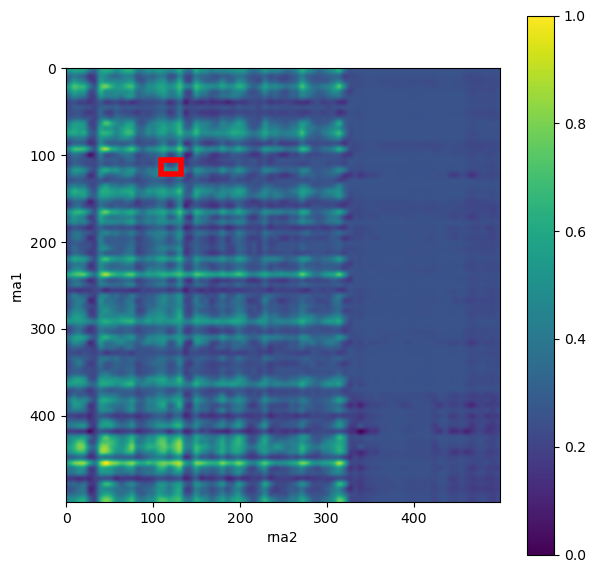

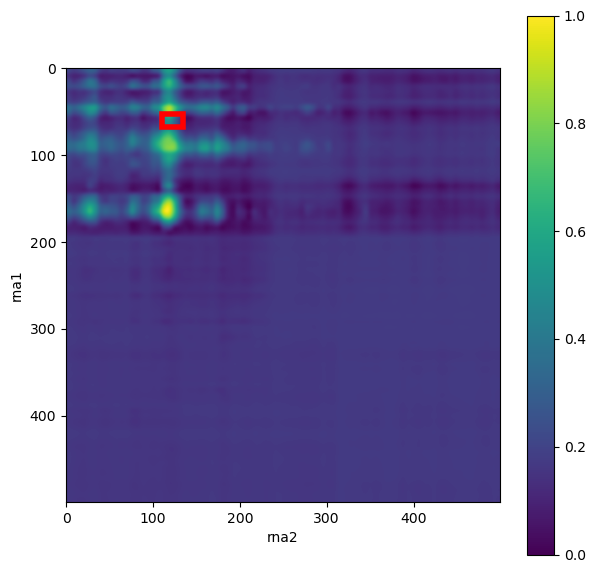

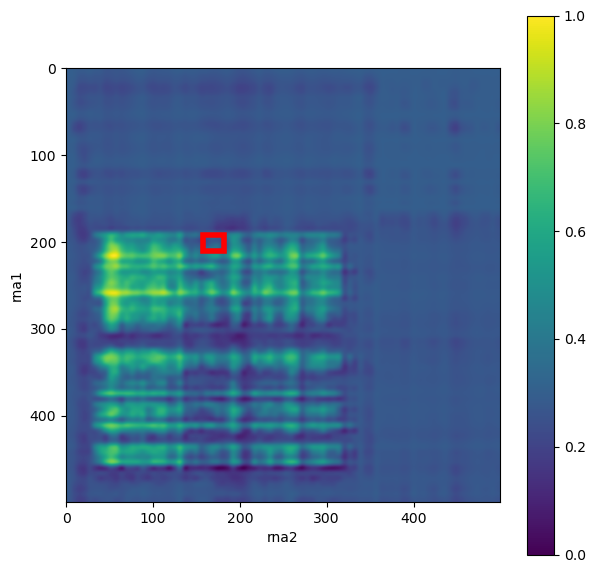

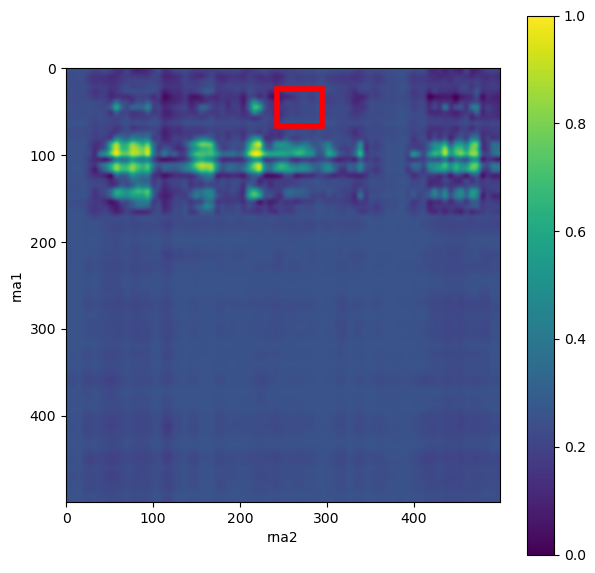

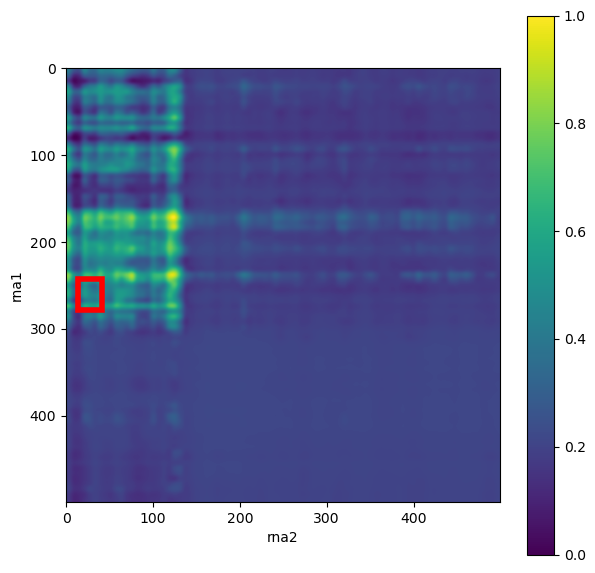

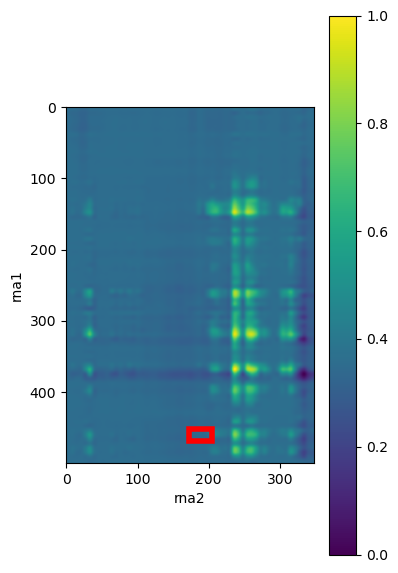

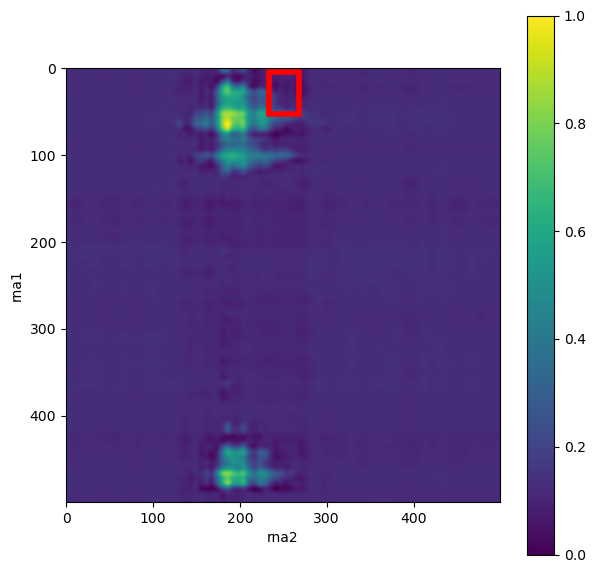

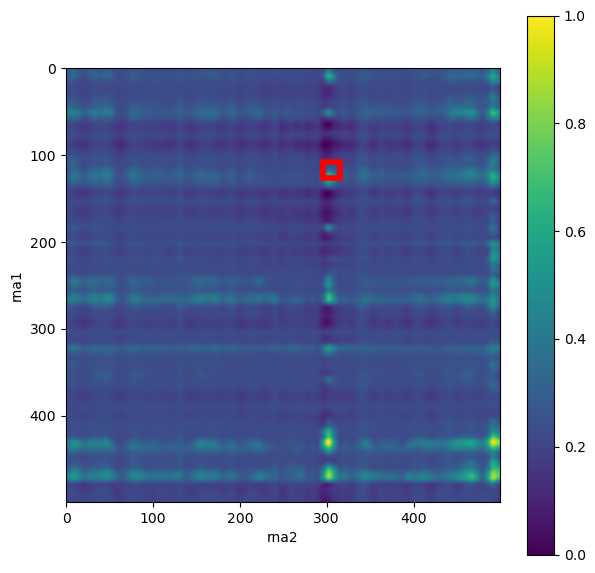

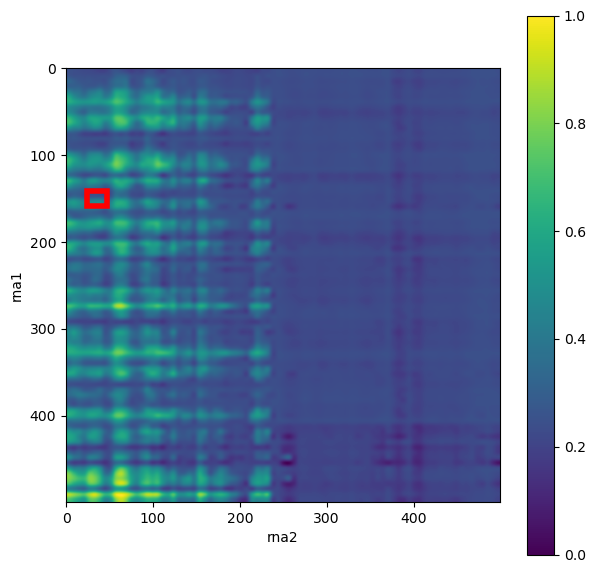

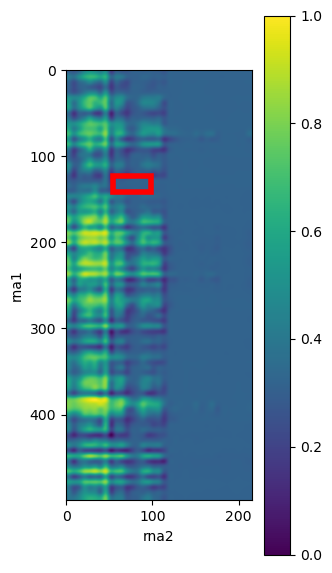

In [96]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability>0.7)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.head(25))

False Negatives

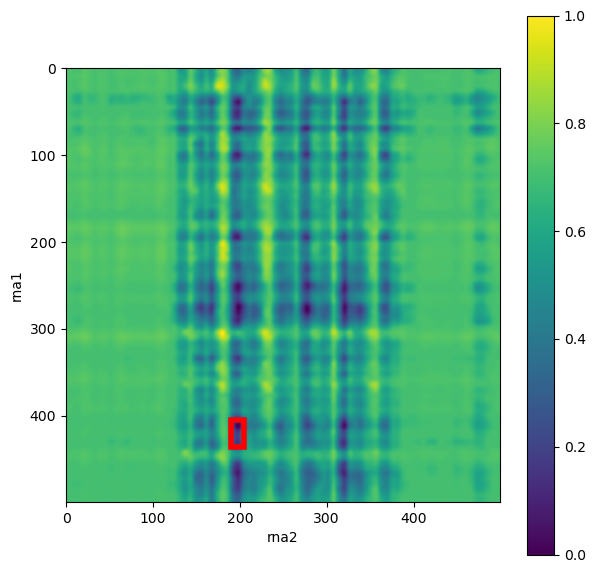

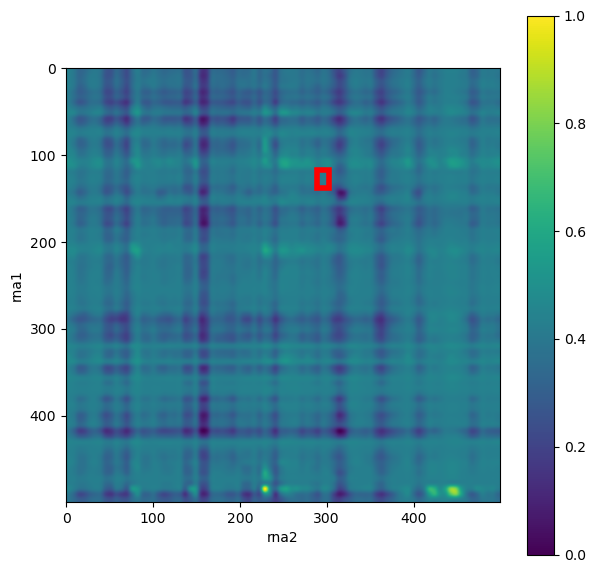

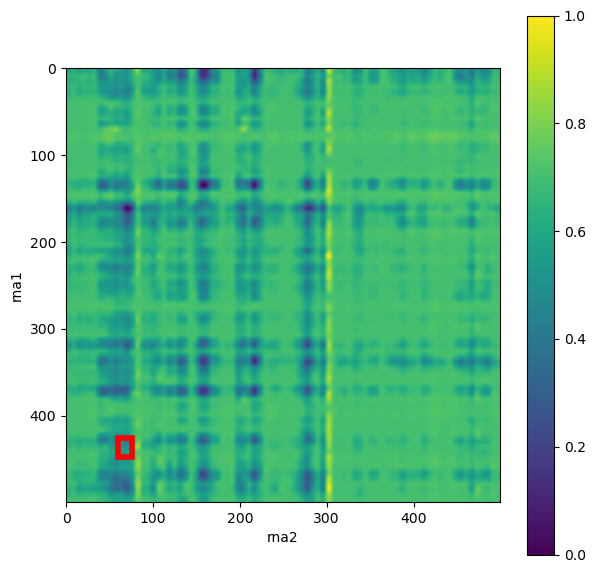

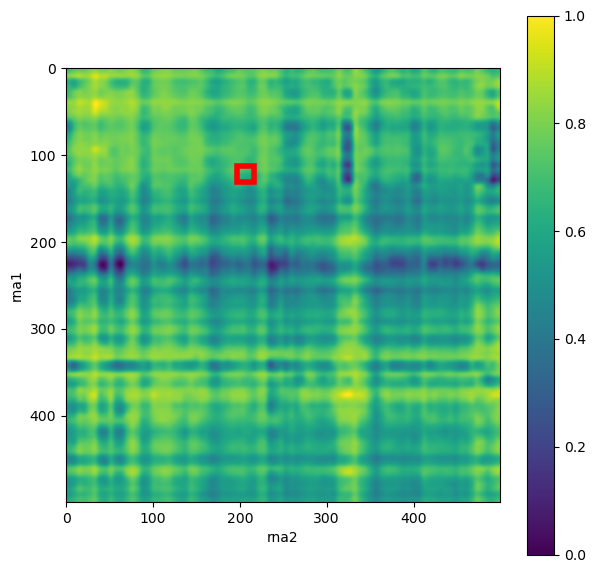

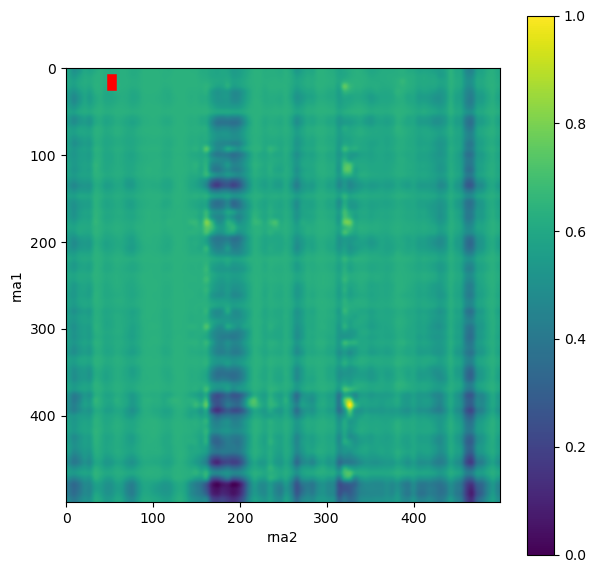

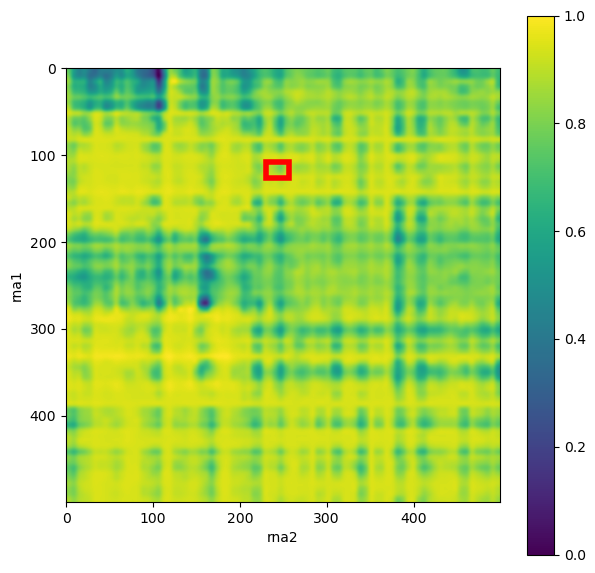

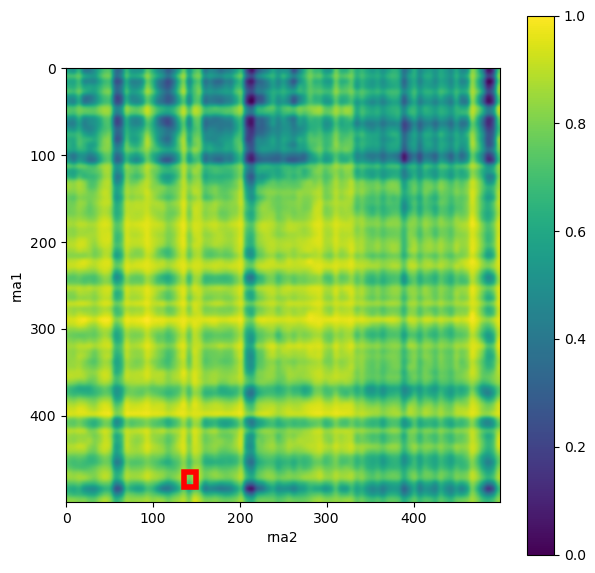

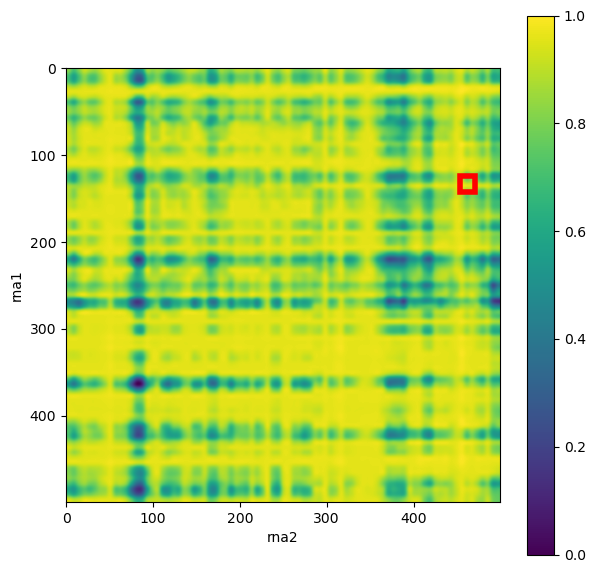

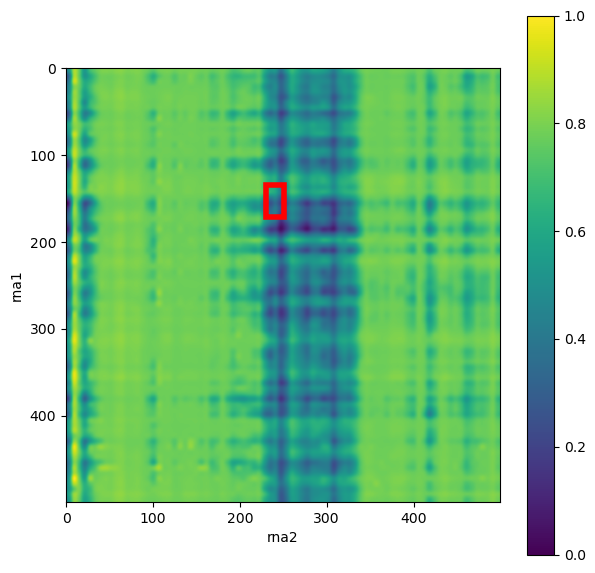

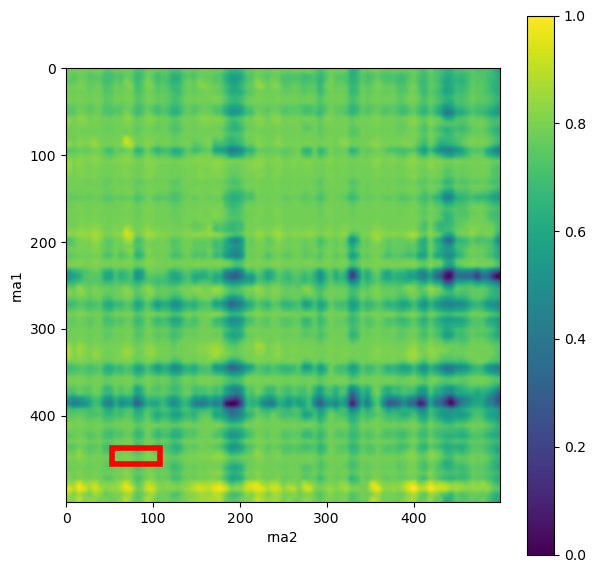

In [109]:
gradcam_results = xai
gradcam_results = gradcam_results[(gradcam_results.probability<0.5)]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.sample(10))

False Negatives, not in train, almost 0.5

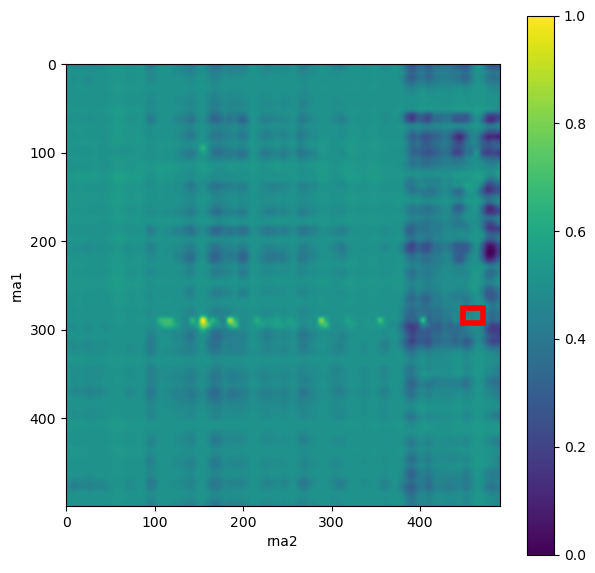

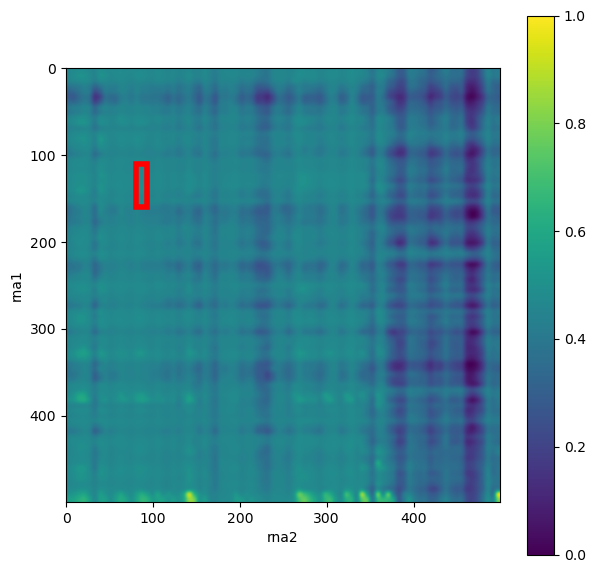

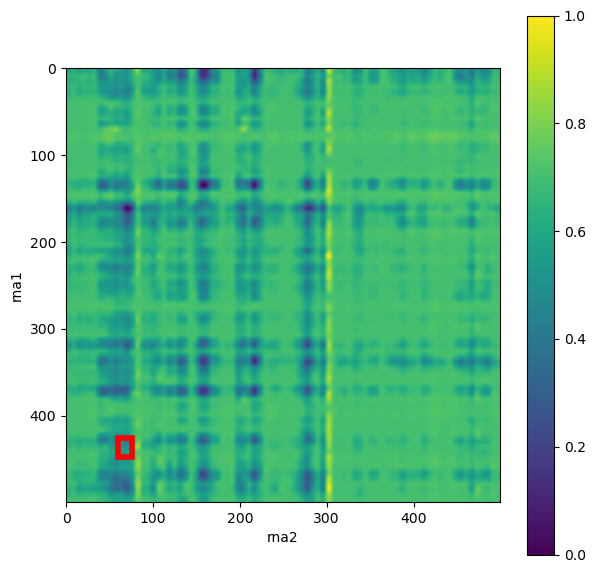

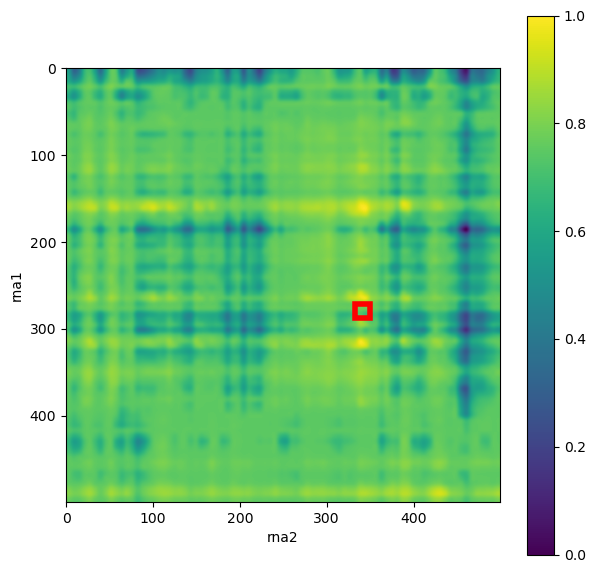

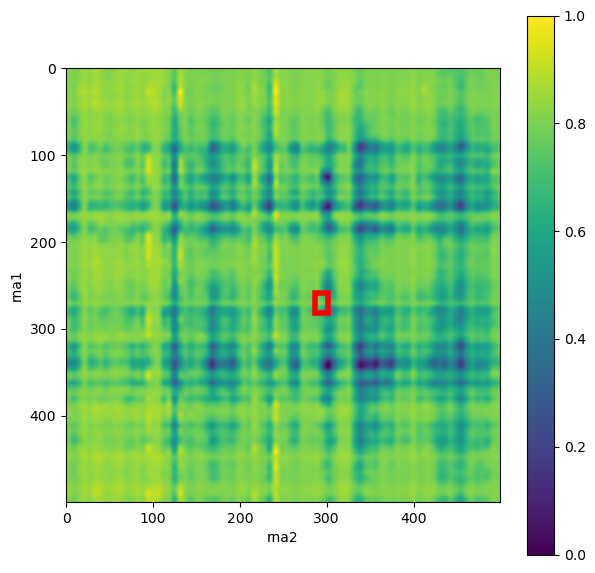

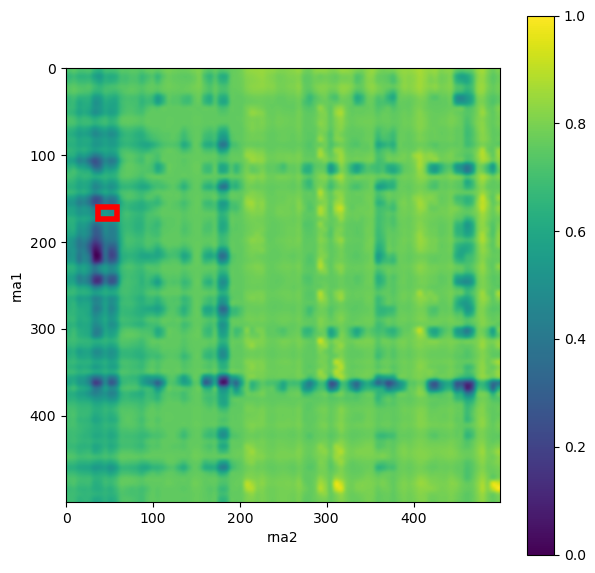

In [105]:
gradcam_results = xai[~(xai.gene1_original.isin(df_train_genes) | xai.gene2_original.isin(df_train_genes))]
gradcam_results = gradcam_results[(gradcam_results.probability<0.5)&((gradcam_results.probability>0.48))]

query = test500[test500.couples.isin(list(gradcam_results.id))].reset_index(drop = True)
query['gene1_original'] = query.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query['gene2_original'] = query.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()[0]
query = query[ ~( (query.gene1_original.isin(df_train_genes)) | (query.gene2_original.isin(df_train_genes)) )]

plot_query_results(query.head(10))

# TROVA UN MODO PER STIMARE BENE LA CORRELAZIONE TRA DEGREE E CONFIDENCE, ci servira per quantificare il problema e creare il regolarizzatore

# CREA SCRIPT PER DEFINIRE IL MIGLIOR MODELLO CONFRONTANDO I DATI DEL VALIDATION SET

# CREA SCRIPT PER MANDARE ESPERIMENTI QUESTA ESTATE